In [2]:

import pandas as pd
from scipy import sparse 
from typing import Optional
import numpy as np
import random as rnd
from sklearn.preprocessing import MinMaxScaler
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# week 1: member 2

data = pd.read_excel(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\sales_and_customer_insights_dirty.xlsx")
print(data.head())



# View basic info
print("\n Dataset Info:")
print(data.info())

print("\n First 5 Rows:")
print(data.head())

print("\n Missing Values Count:")
print(data.isnull().sum())

print("\n Duplicate Rows:", data.duplicated().sum())

print("\n Summary Statistics:")
print(data.describe(include='all'))




# --- Step 3: Check for negative or zero quantities and prices ---
negative_qty = data[data['Quantity'] <= 0]
negative_price = data[data['UnitPrice'] <= 0]

print(f"\n Rows with non-positive quantities: {len(negative_qty)}")
print(f" Rows with non-positive unit prices: {len(negative_price)}")

# --- Step 4: Check country name inconsistencies ---
print("\n Unique countries:\n", data['Country'].unique())

# --- Step 5: Quick check for outliers using describe() ---
print("\n Summary statistics for numeric columns:\n", data.describe())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2       NaN    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0             NaN  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547328 entries, 0 to 547327
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------  

In [3]:

# week 2

# member 1
# --- WEEK 2: Build ETL Pipeline, Handle Missing Data (Member 1 Task) ---

def build_etl_pipeline(file_path: str) -> pd.DataFrame:
    """
    Loads data, cleans column names, converts types, and handles missing values.
    """

    print(f"\n--- Starting ETL Pipeline: Loading {file_path} ---")

    # 1. Extract
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: file not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    # Clean column names
    df.columns = df.columns.str.strip()
    print(f"Initial shape: {df.shape}")

    # Convert types
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

    # Remove invalid rows
    invalid_count = df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)].shape[0]
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

    print(f"Removed {invalid_count} invalid transactions.")
    print(f"Final shape: {df.shape}")

    return df

df = build_etl_pipeline(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\sales_and_customer_insights_dirty.xlsx")
if df is None or not isinstance(df, pd.DataFrame):
    raise RuntimeError("ETL pipeline failed to produce DataFrame — check earlier errors/logs")


# member 2

data= df.copy()
# 1. Remove Duplicate Records

duplicates_before = df.duplicated().sum()
data = data.drop_duplicates()
duplicates_after = data.duplicated().sum()

print(f"Duplicates removed: {duplicates_before - duplicates_after}")


# 2. Handle Missing Values


# a) Fill missing Description with "Unknown Product"
data['Description'] = data['Description'].dropna()

# b) Country missing → Fill as "Unknown"
data['Country'] = data['Country'].fillna("Unknown")

# c) InvoiceDate missing → Remove (these are unusable)
data = data.dropna(subset=['InvoiceDate'])

# d) StockCode & InvoiceNo (critical identifiers) → remove missing
data = data.dropna(subset=['InvoiceNo', 'StockCode'])

# e) CustomerID → Keep but mark missing as -1 for analysis
data['CustomerID'] = data['CustomerID'].fillna(-1)


# 3. Fix Invalid Negative Values

# Negative quantity means returns → keep but tag
data['IsReturn'] = data['Quantity'] < 0



# 4. Standardize Country Names

country_replacements = {
    "RSA": "South Africa",
    "EIRE": "Ireland",
    "European Community": "Europe",
    "Unspecified": "Unknown"
}
data['Country'] = data['Country'].replace(country_replacements)


# 5. Create Calculated Fields (For Week 4 Mining)


# Total price per transaction
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Extract date components
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day


# 6. Save Cleaned Dataset

cleaned_path = "C:/Users/HP/Documents/edu/data mining/group work/DataMining_GroupProject_EcomAnalytics/data/raw/cleaned_data.csv"
data.to_csv(cleaned_path, index=False)
print("\nCLEANING COMPLETE. File saved to:")
print(cleaned_path)


#member 3

# 1. Detect Outliers Using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in Quantity
quantity_outliers, q_low, q_high = detect_outliers_iqr(data, 'Quantity')

# Detect outliers in UnitPrice
price_outliers, p_low, p_high = detect_outliers_iqr(data, 'UnitPrice')

print("=== Quantity Outliers ===")
print(quantity_outliers.head())
print("\nQuantity Lower Bound:", q_low)
print("Quantity Upper Bound:", q_high)

print("\n=== UnitPrice Outliers ===")
print(price_outliers.head())
print("\nUnitPrice Lower Bound:", p_low)
print("UnitPrice Upper Bound:", p_high)

# 2. Suggested Handling Strategies (code-ready)


# Remove negative quantities (invalid)
df_clean = data[data['Quantity'] >= 0]

# Option 1: Remove extremely high outliers
df_clean = df_clean[(df_clean['Quantity'] <= q_high)]
df_clean = df_clean[(df_clean['UnitPrice'] <= p_high)]

# Option 2: Cap values (Winsorization)
df_capped = df_clean.copy()
df_capped['Quantity'] = df_capped['Quantity'].clip(lower=q_low, upper=q_high)
df_capped['UnitPrice'] = df_capped['UnitPrice'].clip(lower=p_low, upper=p_high)

# Remove zero or negative prices
df_no_zero_price = data[data['UnitPrice'] > 0]

print("\nCleaning Completed. DataFrames Created:")
print("- df_no_quantity_outliers: removed extreme quantity outliers")
print("- df_capped: capped extreme values")
print("- df_no_zero_price: removed zero/negative prices")


# member 4
# --- Week 2: Preparation of data for mining (Scaling & Monthly Encoding) ---

def encode_monthly_transactions(df_input: pd.DataFrame, base_path: str):
    """
    Scales features, then splits the data by month, performs one-hot encoding
    for each month, and saves the encoded sparse matrix to separate CSV files.
    """
    print("\n--- Starting Monthly One-Hot Encoding for Apriori Analysis ---")
    
    # 1. Scaling (Performed once on the clean, full data)
    df_scaled = df_input.copy()

    scaler_Q = MinMaxScaler()
    scaler_UP = MinMaxScaler()
    df_scaled['scaled_Q'] = scaler_Q.fit_transform(df_scaled[['Quantity']])
    df_scaled['scaled_UP'] = scaler_UP.fit_transform(df_scaled[['UnitPrice']])
    
    print(f'Max Quantity (Cleaned): {df_scaled["Quantity"].max()}')
    print(f'Min Unit Price (Cleaned): {df_scaled["UnitPrice"].min()}')

    # 2. Iterate through each month and encode separately
    months = sorted(df_scaled['Month'].unique())
    
    for month_num in months:
        month_data = df_scaled[df_scaled['Month'] == month_num].copy()
        month_name = datetime(2023, month_num, 1).strftime('%B')
        
        print(f"\nProcessing {month_name} (Month {month_num}) with {month_data.shape[0]} transactions...")
        
        # Build transactions: list of lists (one transaction per invoice)
        transactions = month_data.groupby('InvoiceNo')['Description'] \
                                .apply(lambda items: items.dropna().astype(str).unique().tolist()) \
                                .tolist()

        if not transactions:
            print(f"Skipping {month_name}: No transactions found after grouping.")
            continue
            
        te = TransactionEncoder()
        te_data = te.fit(transactions).transform(transactions)

        # Convert safely and keep memory-efficient path for sparse matrices
        if sparse.issparse(te_data):
            # Option A: keep sparse and build a sparse-aware DataFrame
            encoded_products = pd.DataFrame.sparse.from_spmatrix(te_data, columns=list(te.columns_))
        else:
            te_array = np.asarray(te_data)
            encoded_products = pd.DataFrame(te_array, columns=list(te.columns_))

        # Ensure ints
        encoded_products = encoded_products.astype(int)

        # Save encoded_products
        # File name now includes the month for clarity
        encoded_products_path = f"{base_path}\\encoded_products_Month_{month_num:02d}.csv"
        encoded_products.to_csv(encoded_products_path, index=True)
        print(f"-> ENCODING COMPLETE for {month_name}. Saved {encoded_products.shape[0]} transactions to: {encoded_products_path}")

# Execute the monthly encoding
base_path = r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw"
encode_monthly_transactions(df_clean, base_path)


--- Starting ETL Pipeline: Loading C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\sales_and_customer_insights_dirty.xlsx ---
Initial shape: (547328, 8)
Removed 11699 invalid transactions.
Final shape: (514256, 8)
Duplicates removed: 8065

CLEANING COMPLETE. File saved to:
C:/Users/HP/Documents/edu/data mining/group work/DataMining_GroupProject_EcomAnalytics/data/raw/cleaned_data.csv
=== Quantity Outliers ===
   InvoiceNo StockCode                        Description  Quantity  \
9     536367     84879      ASSORTED COLOUR BIRD ORNAMENT     320.0   
31    536370     10002                                NaN      48.0   
44    536370     22492            MINI PAINT SET VINTAGE      360.0   
46    536371     22086    PAPER CHAIN KIT 50'S CHRISTMAS       80.0   
58    536373     82486  WOOD S/3 CABINET ANT WHITE FINISH      40.0   

           InvoiceDate  UnitPrice  CustomerID         Country  IsReturn  \
9  2010-12-01 00:00:00       1.69   

['United Kingdom' 'Unknown' 'France' 'Australia' 'Germany' 'Norway'
 'Ireland' 'Switzerland' 'Poland' 'Portugal' 'Italy' 'Belgium' 'Lithuania'
 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Spain' 'Cyprus' 'Finland'
 'Austria' 'Sweden' 'Netherlands' 'Israel' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Brazil' 'USA' 'Europe' 'Bahrain' 'Malta'
 'South Africa']
Rows with Quantity ≤ 0:  0
Rows with unit price ≤ 0:  0
Duplicate InvoiceNo:  393756
Missing Product Descriptions:  8378
Invalid or Missing Dates:  0
purchases per country
                 Country  purchase_totals
0              Australia        12811.800
1                Austria         6177.960
2                Bahrain          212.900
3                Belgium        25139.080
4                 Brazil          928.500
5                 Canada         1740.770
6        Channel Islands        10916.850
7                 Cyprus         7100.310
8         Czech Republ

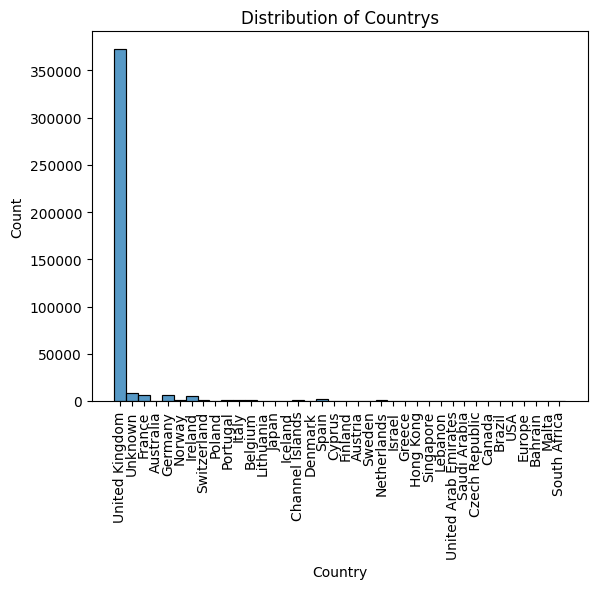

Quantity      1.498444
TotalPrice    3.875923
dtype: float64
Quantity       1.542986
TotalPrice    25.486058
dtype: float64
38
3775
Correlation between Recency and Monetary: -0.04903674768374391
            Recency  Frequency  Monetary
Recency    1.000000  -0.035595 -0.049037
Frequency -0.035595   1.000000  0.995562
Monetary  -0.049037   0.995562  1.000000


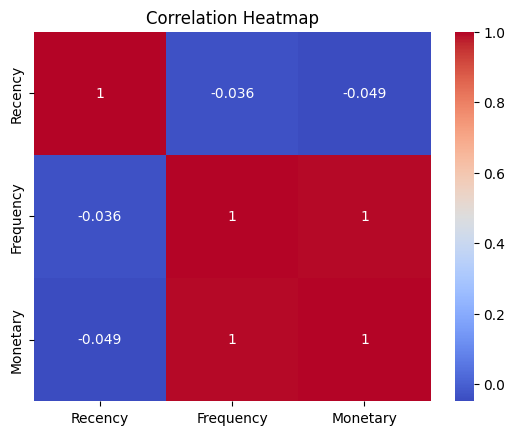

C:\Users\HP\AppData\Local\Temp\ipykernel_13476\862265562.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='purchase_totals', data=purches_countrywise.sort_values('purchase_totals', ascending=False), palette='viridis')


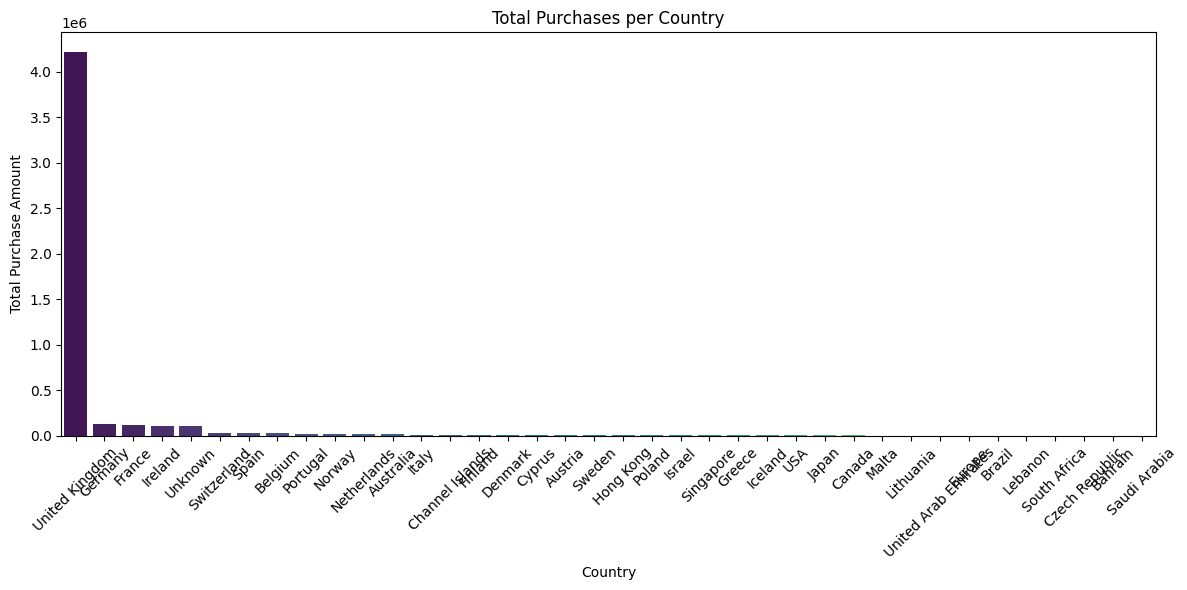

C:\Users\HP\AppData\Local\Temp\ipykernel_13476\862265562.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Unique_Customers', data=customers_per_country.sort_values('Unique_Customers', ascending=False), palette='coolwarm')


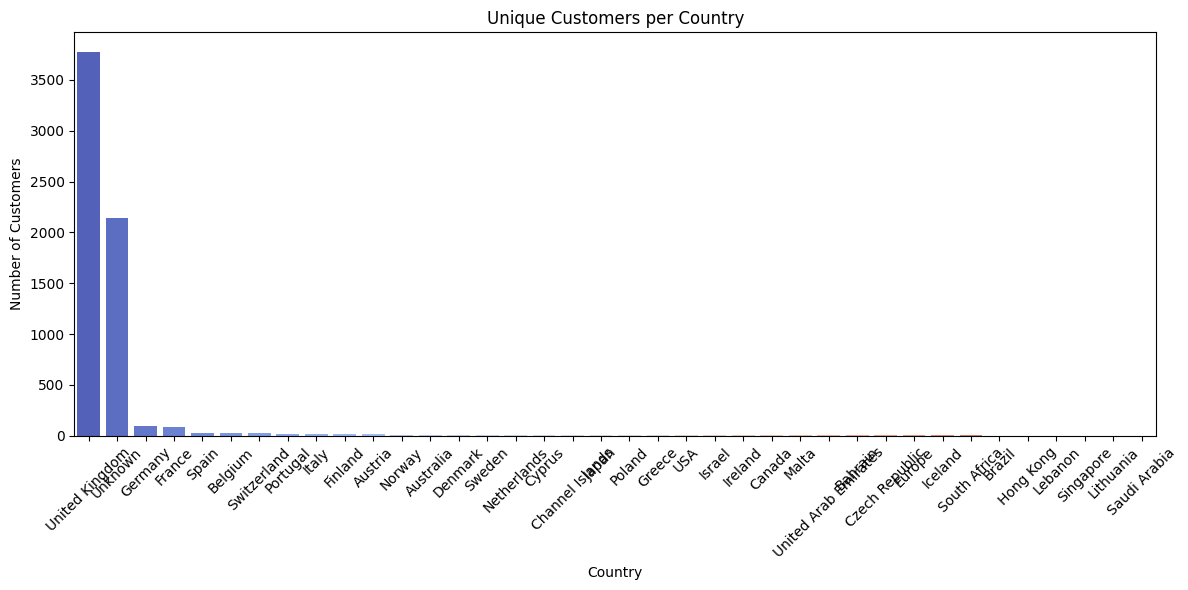

C:\Users\HP\AppData\Local\Temp\ipykernel_13476\862265562.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Description', data=top_items.head(10), palette='magma')


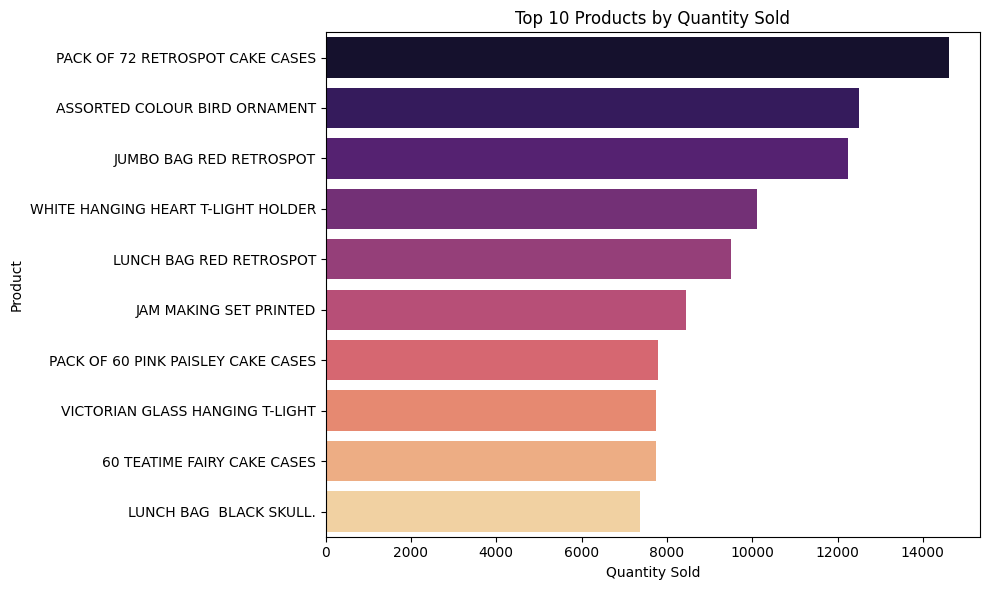

C:\Users\HP\AppData\Local\Temp\ipykernel_13476\862265562.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalPrice', y='Description', data=top_products_revenue.head(10), palette='plasma')


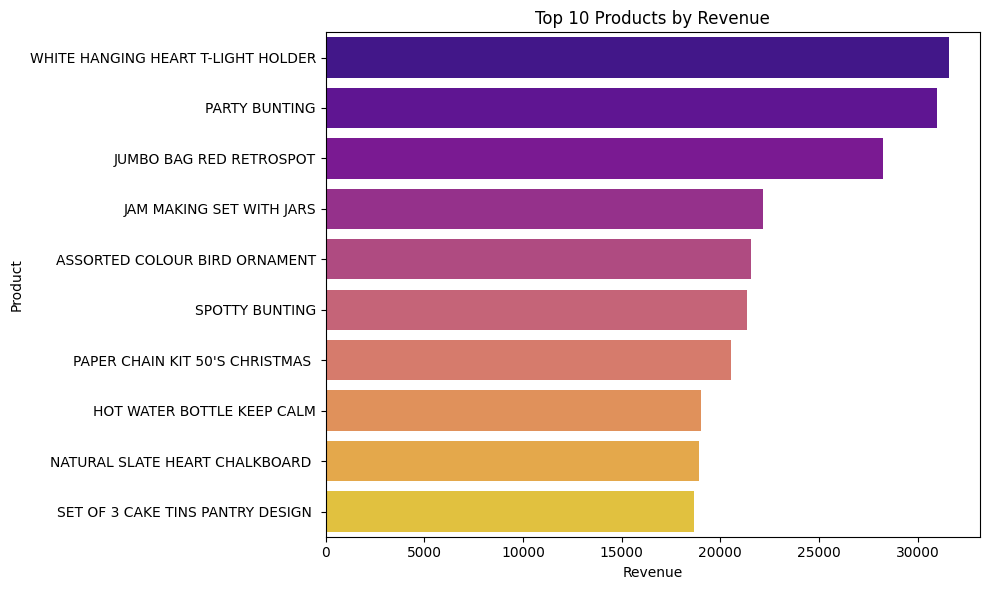

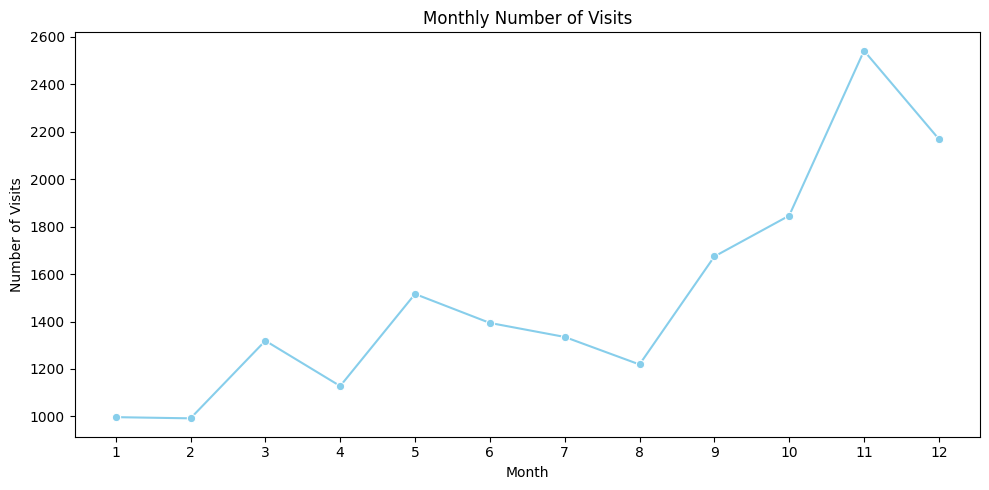

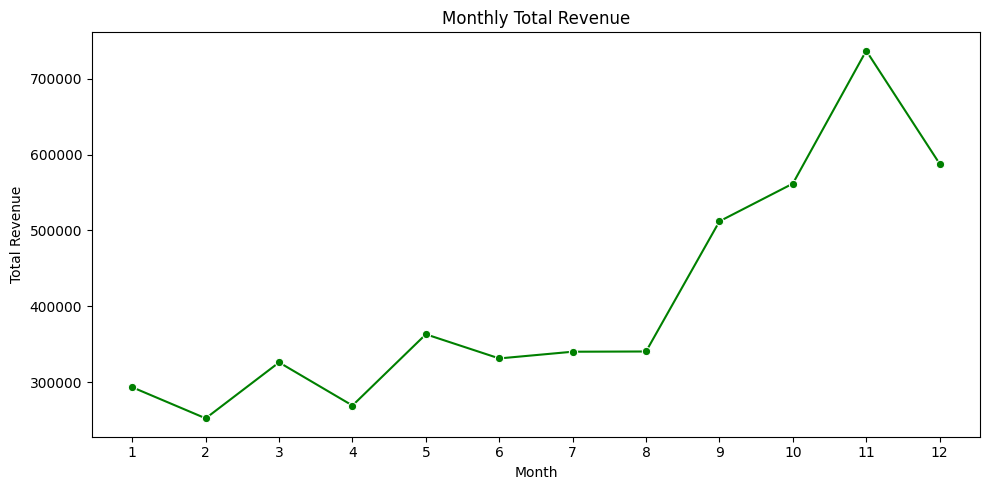

In [4]:
#----Week 3---------
# Week 3: Exploratory Data Analysis

# Member1: Ensure data quality for analysis(sanity checks)
# since cleaning and scaling already done checks done to confirm
# check for unexpected values in country column

unique_countries = df_clean['Country'].unique()
print(unique_countries)

# check for quantity < 0
qty_issues = data[data['Quantity'] <= 0]
print("Rows with Quantity ≤ 0: ", len(qty_issues))

# check for unit price < 0
up_issues = df_clean[df_clean['UnitPrice'] <= 0]
print("Rows with unit price ≤ 0: ", len(up_issues))

# Check for Duplicate InvoiceNo ( decided to ignore since multiple products can be bought at one time)
dup_inv_count = df_clean['InvoiceNo'].duplicated().sum()
print("Duplicate InvoiceNo: ", dup_inv_count)

# Check for Missing Product Descriptions
missing_prod_count = df_clean['Description'].isnull().sum()
print("Missing Product Descriptions: ", missing_prod_count)

# Check for Invalid or Missing Dates
inv_dates_count = df_clean[df_clean['InvoiceDate'].isnull()].shape[0]
print("Invalid or Missing Dates: ", inv_dates_count)

# Passed sanity check

# Member2: Create demographic and geographic analyses
# 1.) purchases per country
df_clean['Quantity'] = df_clean['Quantity'].fillna(0)
# create a new column purchase_totals that is the product of quantity and unitprice
purchase_totals =  df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['purchase_totals'] = purchase_totals
# purchases per country
purches_countrywise = df_clean.groupby('Country')['purchase_totals'].sum().reset_index()
print('purchases per country')
print(purches_countrywise)

# 2.) Top item purchases
top_items = df_clean.groupby('Description')['Quantity'].sum().reset_index()
top_items = top_items.sort_values(by='Quantity', ascending=False)
print('Top item purchases')
print(top_items.head(10))

# 3.) Customer count per country
customers_per_country = df_clean.groupby('Country')['CustomerID'].nunique().reset_index()
customers_per_country.rename(columns={'CustomerID': 'Unique_Customers'}, inplace=True)

print(customers_per_country)

# 4.) Average purchases per visit
avg_purchase_per_visit = df_clean.groupby('InvoiceNo')['TotalPrice'].mean().reset_index()
avg_purchase_per_visit

# 5.) RFM-based customer segmentation( how much each customer bought when they last bought)
# Change invoice date to date time
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# change customer id to string
df_clean['CustomerID'] = df_clean['CustomerID'].astype(str)

# confirm datatypes before proceeding
df_clean.dtypes

# Separate colums to use
rmf_df = df_clean[['CustomerID', 'InvoiceDate', 'TotalPrice','InvoiceNo']].copy()

# Get most recent date from Invoice date
most_recent_date = rmf_df['InvoiceDate'].max()
print(most_recent_date)

today_date= pd.to_datetime('2012-01-01')

# Aggregate to customer-level RFM
rfm_df = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda v: (today_date - v.max()).days,  # Recency
    'InvoiceNo': 'count',                                  # Frequency
    'TotalPrice': 'sum'                                    # Monetary
}).reset_index()

# Rename columns
rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# RFM scoring
r = pd.qcut(rfm_df['Recency'], q=5, labels=[5,4,3,2,1])
f = pd.qcut(rfm_df['Frequency'], q=5, labels=[1,2,3,4,5], duplicates='drop')
m = pd.qcut(rfm_df['Monetary'], q=5, labels=[1,2,3,4,5], duplicates='drop')

# Add scores
rfm = rfm_df.assign(R=r.values, F=f.values, M=m.values)
print(rfm.head())

# Member3: Lead statistical analysis and correlation studies

# 1.)summary statistics
print(df_clean[['Quantity','TotalPrice']].describe())

# average purchases per country
avg_purchases_per_country = df_clean.groupby('Country')['TotalPrice'].mean().reset_index()
print('the top 10 highest averaging countries: \n')
avg_purchases_per_country.head(10)

# distributions
sns.histplot(df_clean['Country'])
plt.title('Distribution of Countrys')
plt.xticks(rotation=90)
plt.show()

# test for skewness and kurtosis
print(df_clean[['Quantity','TotalPrice']].skew())
print(df_clean[['Quantity','TotalPrice']].kurt())

# No. of unique vals in categorical columns
print(df_clean['Country'].nunique())
print(df_clean['Description'].nunique())


# correlation btn recency & monetary
correlation = rfm['Recency'].corr(rfm['Monetary'])
print(f"Correlation between Recency and Monetary: {correlation}")

corr_matrix = rfm_df[['Recency','Frequency','Monetary']].corr()
print(corr_matrix)

# Heatmap for visual understanding
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Member4: Prepare feature selection for mining phase
# describe goal
# Association rules needs- InvoiceNo, CustomerID, Description, Quantity.
# RFM clustering needs- Recency, Frequency, Monetary.
# Identify  available features:

# Numeric: Recency,Frequency,Monetary,Quantity,Totalprice
# Categorical: Country, Product Category(also encoded ), CustomerID , IsReturn(bool)

# Have the relevant features in 1 df

# make df for rfm Segmentation
df_rfm = rfm_df.copy()

# Make df for apriori

# df_apriori= encoded_products.copy()

# # encode the left non nominal data(country)
# df_features = pd.get_dummies(df_features, columns=['Country'], drop_first=True)
# df_features.head()

# # save features df
# df_features = r"/content/drive/MyDrive/DataMining_GroupProject_EcomAnalytics/data/raw/df_features.xlsx"
# data.to_excel(cleaned_path, index=False)
# print(f"\nCLEANING COMPLETE. File saved to: df_features")

# splitting won't be done now since apriori and RFM Segmentation don't require spliting

# Member5: Create EDA visualization portfolio

# Total purchases per country
plt.figure(figsize=(12,6))
sns.barplot(x='Country', y='purchase_totals', data=purches_countrywise.sort_values('purchase_totals', ascending=False), palette='viridis')
plt.title('Total Purchases per Country')
plt.xticks(rotation=45)
plt.ylabel('Total Purchase Amount')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

# Unique customers per country

plt.figure(figsize=(12,6))
sns.barplot(x='Country', y='Unique_Customers', data=customers_per_country.sort_values('Unique_Customers', ascending=False), palette='coolwarm')
plt.title('Unique Customers per Country')
plt.xticks(rotation=45)
plt.ylabel('Number of Customers')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

# Top 10 products by quantity
plt.figure(figsize=(10,6))
sns.barplot(x='Quantity', y='Description', data=top_items.head(10), palette='magma')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Top 10 products by revenue

top_products_revenue = df_clean.groupby('Description')['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='TotalPrice', y='Description', data=top_products_revenue.head(10), palette='plasma')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Monthly visits
# make a new df with month and count of invoices
monthly_visits = df_clean.groupby('Month')['InvoiceNo'].nunique().reset_index()
monthly_visits.rename(columns={'InvoiceNo': 'TotalVisits'}, inplace=True)

plt.figure(figsize=(10,5))
sns.lineplot(x='Month', y='TotalVisits', data=monthly_visits, marker='o', color='skyblue')
plt.title('Monthly Number of Visits')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

# Total revenue over time

monthly_revenue = df_clean.groupby('Month')['TotalPrice'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='Month', y='TotalPrice', data=monthly_revenue, marker='o', color='green')
plt.title('Monthly Total Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

--- Running K-Means and Calculating Silhouette Scores ---
K=2: Silhouette Score=0.7397
K=3: Silhouette Score=0.6781
K=4: Silhouette Score=0.6132
K=5: Silhouette Score=0.6097
K=6: Silhouette Score=0.6094
K=7: Silhouette Score=0.6048
K=8: Silhouette Score=0.5636
K=9: Silhouette Score=0.5634
K=10: Silhouette Score=0.5693

The optimal K is the one with the highest average Silhouette Score.


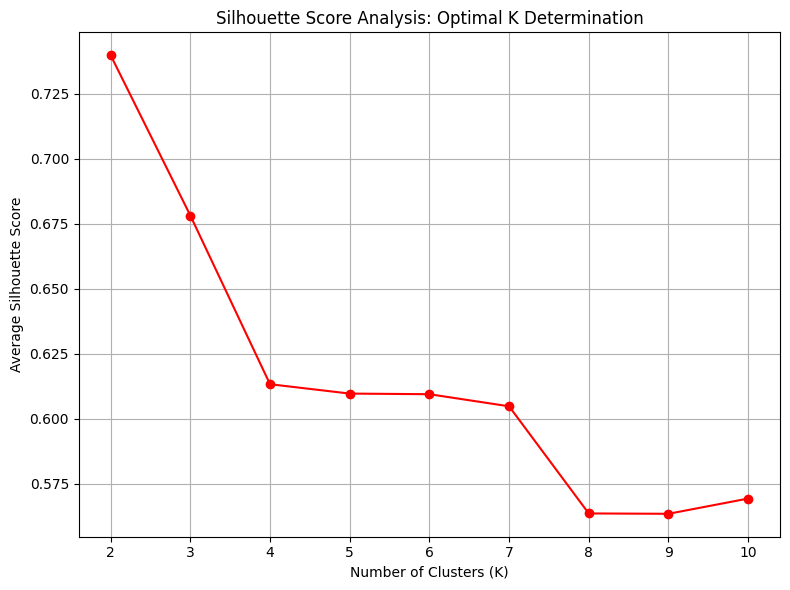


Conclusion: Based on the Silhouette Score, the statistically suggested optimal K is: 2
You should now update your K-Means model to use n_clusters=2 for the final segmentation.

First 5 Customers with Cluster ID:
  CustomerID  Cluster
0       -1.0        2
1    12347.0        2
2    12348.0        1
3    12349.0        2
4    12350.0        1


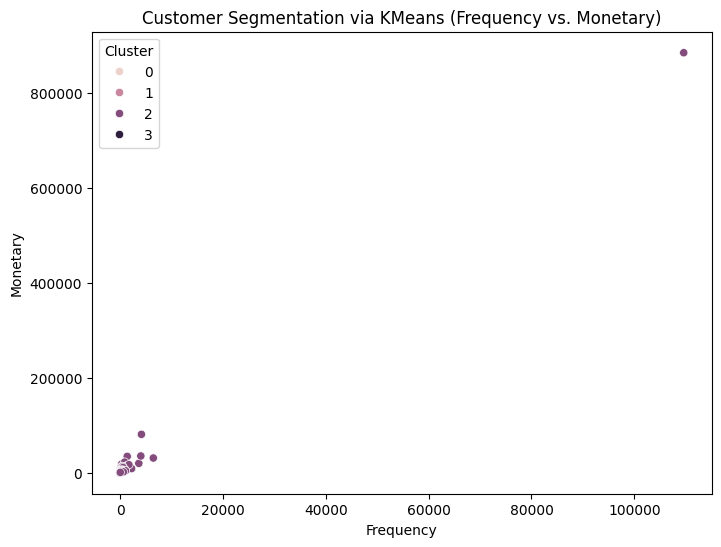

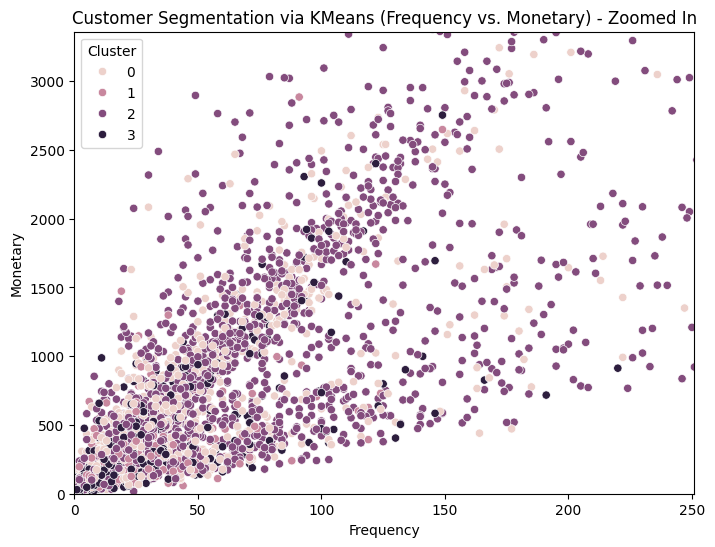

CustomerID     object
Recency         int64
Frequency       int64
Monetary      float64
Cluster         int32
R               int64
F               int64
M               int64
dtype: object

KMeans Cluster Means (Average R, F, M scores per segment):
                R         F         M     Recency   Frequency     Monetary
Cluster                                                                   
0        2.452081  2.743466  2.893514   99.787028   43.065828   634.814638
1        1.000000  1.866126  1.809331  328.334686   19.070994   247.038154
2        4.243891  3.578201  3.569404   40.711144  166.495601  1912.671330
3        1.450567  2.236629  2.241491  209.085900   28.115073   363.654864


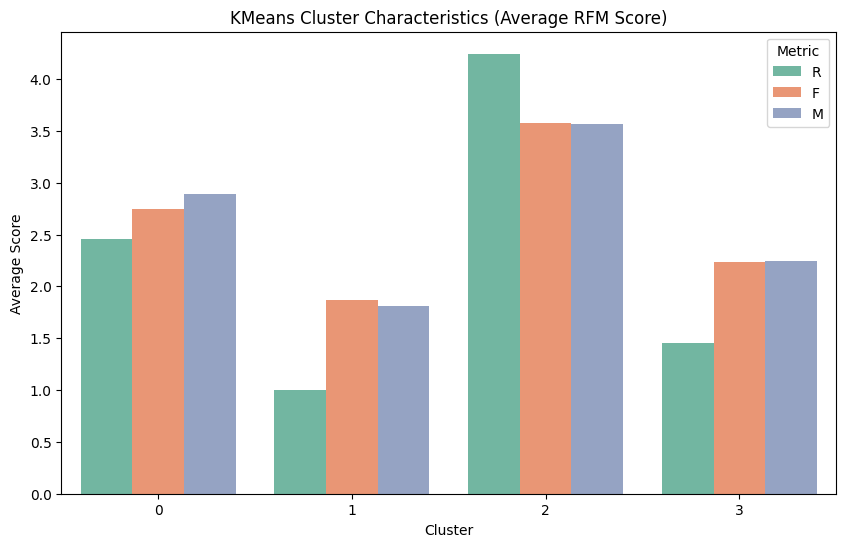


Cluster Sizes:
Cluster
0    1033
1     493
2    2046
3     617
Name: count, dtype: int64


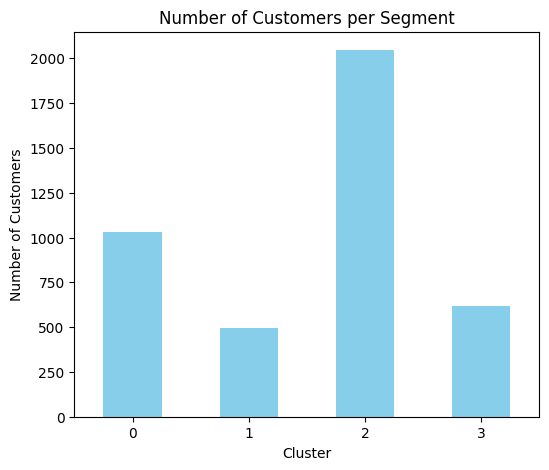

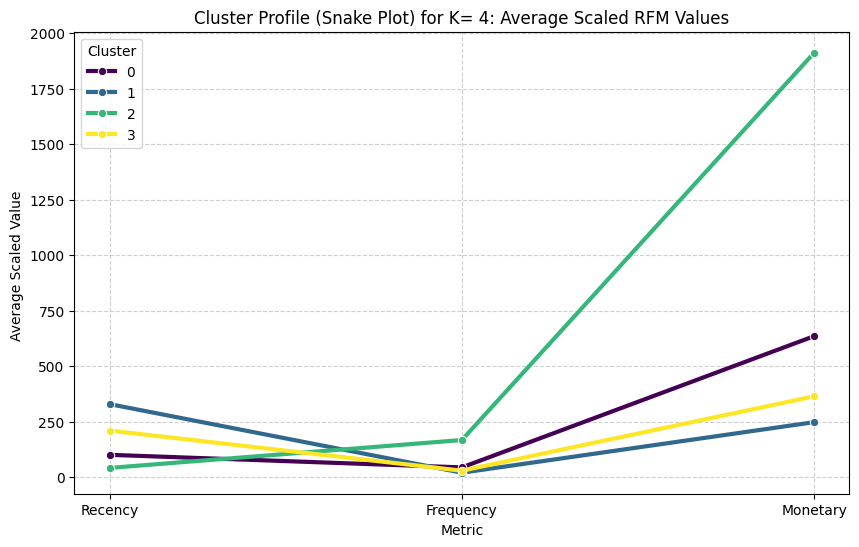


Snake Plot Interpretation Keys:
- High Recency (closer to 1) means very recent purchase.
- Low Recency (closer to 0) means purchase was long ago.
- High Frequency/Monetary (closer to 1) means high value metrics.

Cluster 0: Low value, inactive customers → offer discounts
Cluster 1: High value VIP customers → loyalty rewards
Cluster 2: New customers → onboarding campaigns
Cluster 3: Medium customers → upselling strategies


Basket DataFrame Head:
    4 PURPLE FLOCK DINNER CANDLES   OVAL WALL MIRROR DIAMANTE   \
0                             0.0                            0   
1                             0.0                            0   
2                             0.0                            0   
3                             0.0                            0   
4                             0.0                            0   

    SET 2 TEA TOWELS I LOVE LONDON   10 COLOUR SPACEBOY PEN  \
0                               0.0                       0   
1                         

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head:
    support                               itemsets
0  0.031093     ( SET 2 TEA TOWELS I LOVE LONDON )
1  0.021063  (12 PENCILS SMALL TUBE RED RETROSPOT)
2  0.021063          (12 PENCILS SMALL TUBE SKULL)
3  0.025075   (3 PIECE SPACEBOY COOKIE CUTTER SET)
4  0.023069    (3 WHITE CHOC MORRIS BOXED CANDLES)

Top Association Rules Jan (confidence >= 0.3):
                                              antecedents  \
326395  (S/4 VALENTINE DECOUPAGE HEART BOX, DECORATIVE...   
227580  (FRYING PAN BLUE POLKADOT, METAL SIGN,CUPCAKE ...   
320233  (DECORATIVE ROSE BATHROOM BOTTLE, CAKES AND BO...   
326691  (HEARTS GIFT TAPE, BLUE ROSE FABRIC MIRROR, CA...   
212323  (CAKES AND BOWS GIFT  TAPE, DECORATION  BUTTER...   

                                              consequents  support  \
326395  (METAL SIGN,CUPCAKE SINGLE HOOK, HEARTS GIFT T...  0.02006   
227580  (BISCUITS SMALL BOWL LIGHT BLUE, CAKES AND BOW...  0.02006   
320233  (S/4 VALENTINE DECOU

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head:
    support                              itemsets
0  0.032258    ( SET 2 TEA TOWELS I LOVE LONDON )
1  0.025202             (20 DOLLY PEGS RETROSPOT)
2  0.024194  (3 PIECE SPACEBOY COOKIE CUTTER SET)
3  0.025202            (3 STRIPEY MICE FELTCRAFT)
4  0.054435              (6 RIBBONS RUSTIC CHARM)

Top Association Rules Feb (confidence >= 0.3):
                            antecedents                          consequents  \
10                 (PINK POLKADOT BOWL)                 (BLUE POLKADOT BOWL)   
9                  (BLUE POLKADOT BOWL)                 (PINK POLKADOT BOWL)   
6   (BLUE 3 PIECE POLKADOT CUTLERY SET)  (PINK 3 PIECE POLKADOT CUTLERY SET)   
5   (PINK 3 PIECE POLKADOT CUTLERY SET)  (BLUE 3 PIECE POLKADOT CUTLERY SET)   
8        (CREAM FELT EASTER EGG BASKET)        (BLUE FELT EASTER EGG BASKET)   

     support  confidence       lift  
10  0.021169    0.700000  25.718519  
9   0.021169    0.777778  25.718519  
6   0.020161    

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head:
    support                               itemsets
0  0.023503     ( SET 2 TEA TOWELS I LOVE LONDON )
1  0.024261  (12 PENCILS SMALL TUBE RED RETROSPOT)
2  0.021986   (3 PIECE SPACEBOY COOKIE CUTTER SET)
3  0.053829               (6 RIBBONS RUSTIC CHARM)
4  0.022745      (60 CAKE CASES DOLLY GIRL DESIGN)

Top Association Rules Mar (confidence >= 0.3):
                                           antecedents  \
7                               (DOLLY GIRL LUNCH BOX)   
6                                (SPACEBOY LUNCH BOX )   
103  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
104                  (GREEN REGENCY TEACUP AND SAUCER)   
102  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   

                                           consequents   support  confidence  \
7                                (SPACEBOY LUNCH BOX )  0.023503    0.632653   
6                               (DOLLY GIRL LUNCH BOX)  0.023503    0.553571   
103             

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head:
    support                            itemsets
0  0.028369  ( SET 2 TEA TOWELS I LOVE LONDON )
1  0.043440            (6 RIBBONS RUSTIC CHARM)
2  0.020390   (60 CAKE CASES DOLLY GIRL DESIGN)
3  0.061170       (60 TEATIME FAIRY CAKE CASES)
4  0.024823    (72 SWEETHEART FAIRY CAKE CASES)

Top Association Rules Apr (confidence >= 0.3):
                      antecedents                    consequents   support  \
6   (CHARLOTTE BAG PINK POLKADOT)     (STRAWBERRY CHARLOTTE BAG)  0.020390   
7      (STRAWBERRY CHARLOTTE BAG)  (CHARLOTTE BAG PINK POLKADOT)  0.020390   
5   (RED RETROSPOT CHARLOTTE BAG)  (CHARLOTTE BAG PINK POLKADOT)  0.021277   
4   (CHARLOTTE BAG PINK POLKADOT)  (RED RETROSPOT CHARLOTTE BAG)  0.021277   
94   (WATERING CAN BLUE ELEPHANT)      (WATERING CAN PINK BUNNY)  0.021277   

    confidence       lift  
6     0.676471  18.611191  
7     0.560976  18.611191  
5     0.470588  15.612457  
4     0.705882  15.612457  
94    0.521739

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                               itemsets
0  0.022427  (12 PENCILS SMALL TUBE RED RETROSPOT)
1  0.034960               (6 RIBBONS RUSTIC CHARM)
2  0.042216          (60 TEATIME FAIRY CAKE CASES)
3  0.022427       (72 SWEETHEART FAIRY CAKE CASES)
4  0.023747           (ALARM CLOCK BAKELIKE IVORY)

Top Association Rules May (confidence >= 0.3):
                                           antecedents  \
9                                   (HERB MARKER MINT)   
10                               (HERB MARKER PARSLEY)   
0                        (BLUE HAPPY BIRTHDAY BUNTING)   
1                        (PINK HAPPY BIRTHDAY BUNTING)   
190  (REGENCY TEA PLATE ROSES , REGENCY TEA PLATE P...   

                       consequents   support  confidence       lift  
9            (HERB MARKER PARSLEY)  0.020449    0.861111  38.395425  
10              (HERB MARKER MINT)  0.020449    0.911765  38.395425  
0    (PINK HAPPY BIRTHDAY BUNTING)  0.020449 

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                          itemsets
0  0.021521     (4 TRADITIONAL SPINNING TOPS)
1  0.035868          (6 RIBBONS RUSTIC CHARM)
2  0.031564     (60 TEATIME FAIRY CAKE CASES)
3  0.020086  (72 SWEETHEART FAIRY CAKE CASES)
4  0.021521    (AIRLINE BAG VINTAGE TOKYO 78)

Top Association Rules Jun (confidence >= 0.3):
                              antecedents  \
141            (REGENCY SUGAR BOWL GREEN)   
142              (REGENCY MILK JUG PINK )   
152        (SMALL MARSHMALLOWS PINK BOWL)   
153  (SMALL DOLLY MIX DESIGN ORANGE BOWL)   
143            (REGENCY TEA PLATE ROSES )   

                              consequents   support  confidence       lift  
141              (REGENCY MILK JUG PINK )  0.025108    0.760870  23.057656  
142            (REGENCY SUGAR BOWL GREEN)  0.025108    0.760870  23.057656  
152  (SMALL DOLLY MIX DESIGN ORANGE BOWL)  0.021521    0.652174  20.662055  
153        (SMALL MARSHMALLOWS PINK BOWL)  0.021521    

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                           itemsets
0  0.020974        (12 PENCILS TALL TUBE POSY)
1  0.025468      (4 TRADITIONAL SPINNING TOPS)
2  0.041199           (6 RIBBONS RUSTIC CHARM)
3  0.020225  (60 CAKE CASES DOLLY GIRL DESIGN)
4  0.033708      (60 TEATIME FAIRY CAKE CASES)

Top Association Rules Jul (confidence >= 0.3):
                  antecedents                  consequents   support  \
7  (BLUE VINTAGE SPOT BEAKER)    (RED VINTAGE SPOT BEAKER)  0.020974   
6   (RED VINTAGE SPOT BEAKER)   (BLUE VINTAGE SPOT BEAKER)  0.020974   
4  (PINK VINTAGE SPOT BEAKER)   (BLUE VINTAGE SPOT BEAKER)  0.023221   
5  (BLUE VINTAGE SPOT BEAKER)   (PINK VINTAGE SPOT BEAKER)  0.023221   
2  (BLUE VINTAGE SPOT BEAKER)  (GREEN VINTAGE SPOT BEAKER)  0.021723   

   confidence       lift  
7    0.560000  20.205405  
6    0.756757  20.205405  
4    0.756098  20.187805  
5    0.620000  20.187805  
2    0.580000  18.435714  


c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                           itemsets
0  0.030353               ( DOLLY GIRL BEAKER)
1  0.021329      (4 TRADITIONAL SPINNING TOPS)
2  0.055783           (6 RIBBONS RUSTIC CHARM)
3  0.021329  (60 CAKE CASES DOLLY GIRL DESIGN)
4  0.039377      (60 TEATIME FAIRY CAKE CASES)

Top Association Rules Aug (confidence >= 0.3):
                                           antecedents  \
246                         (REGENCY TEA PLATE GREEN )   
247                           (REGENCY TEA PLATE PINK)   
358                         (REGENCY TEA PLATE ROSES )   
357  (ROSES REGENCY TEACUP AND SAUCER , REGENCY TEA...   
355  (REGENCY TEA PLATE ROSES , ROSES REGENCY TEACU...   

                                           consequents   support  confidence  \
246                           (REGENCY TEA PLATE PINK)  0.022149    0.710526   
247                         (REGENCY TEA PLATE GREEN )  0.022149    0.900000   
358  (ROSES REGENCY TEACUP AND SAUCER ,

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                               itemsets
0  0.025687  (15CM CHRISTMAS GLASS BALL 20 LIGHTS)
1  0.021505             (3 STRIPEY MICE FELTCRAFT)
2  0.029271         (36 DOILIES VINTAGE CHRISTMAS)
3  0.021505          (4 TRADITIONAL SPINNING TOPS)
4  0.029271          (6 GIFT TAGS 50'S CHRISTMAS )

Top Association Rules Sep (confidence >= 0.3):
                                           antecedents  \
150                         (REGENCY SUGAR BOWL GREEN)   
151                           (REGENCY MILK JUG PINK )   
174  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
175                   (PINK REGENCY TEACUP AND SAUCER)   
176                  (GREEN REGENCY TEACUP AND SAUCER)   

                                           consequents   support  confidence  \
150                           (REGENCY MILK JUG PINK )  0.020908    0.729167   
151                         (REGENCY SUGAR BOWL GREEN)  0.020908    0.714286   
174            

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                               itemsets
0  0.022210       ( 50'S CHRISTMAS GIFT BAG LARGE)
1  0.020043               (10 COLOUR SPACEBOY PEN)
2  0.025460        (12 PENCIL SMALL TUBE WOODLAND)
3  0.022210  (12 PENCILS SMALL TUBE RED RETROSPOT)
4  0.025460          (12 PENCILS SMALL TUBE SKULL)

Top Association Rules Oct (confidence >= 0.3):
                           antecedents                        consequents  \
19    (PINK REGENCY TEACUP AND SAUCER)  (GREEN REGENCY TEACUP AND SAUCER)   
18   (GREEN REGENCY TEACUP AND SAUCER)   (PINK REGENCY TEACUP AND SAUCER)   
66          (ROLL WRAP 50'S CHRISTMAS)    (ROLL WRAP 50'S RED CHRISTMAS )   
65     (ROLL WRAP 50'S RED CHRISTMAS )         (ROLL WRAP 50'S CHRISTMAS)   
21  (ROSES REGENCY TEACUP AND SAUCER )  (GREEN REGENCY TEACUP AND SAUCER)   

     support  confidence       lift  
19  0.020043    0.725490  20.925858  
18  0.020043    0.578125  20.925858  
66  0.022752    0.525000  1

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                               itemsets
0  0.040535        (12 PENCIL SMALL TUBE WOODLAND)
1  0.025580  (12 PENCILS SMALL TUBE RED RETROSPOT)
2  0.020464   (12 PENCILS TALL TUBE RED RETROSPOT)
3  0.025580          (12 PENCILS TALL TUBE SKULLS)
4  0.029122  (15CM CHRISTMAS GLASS BALL 20 LIGHTS)

Top Association Rules Nov (confidence >= 0.3):
                                           antecedents  \
131  (SET OF 3 WOODEN HEART DECORATIONS, SET OF 3 W...   
136                 (SET OF 3 WOODEN TREE DECORATIONS)   
135              (SET OF 3 WOODEN STOCKING DECORATION)   
132  (SET OF 3 WOODEN HEART DECORATIONS, SET OF 3 W...   
141                 (SET OF 3 WOODEN TREE DECORATIONS)   

                                           consequents   support  confidence  \
131                 (SET OF 3 WOODEN TREE DECORATIONS)  0.020464    0.838710   
136  (SET OF 3 WOODEN HEART DECORATIONS, SET OF 3 W...  0.020464    0.490566   
135  (SET OF 3 

c:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Frequent Items (min_support=0.02) Head :
    support                               itemsets
0  0.028124     ( SET 2 TEA TOWELS I LOVE LONDON )
1  0.031351        (12 PENCIL SMALL TUBE WOODLAND)
2  0.026740  (12 PENCILS SMALL TUBE RED RETROSPOT)
3  0.028585   (3 HEARTS HANGING DECORATION RUSTIC)
4  0.023052   (3 PIECE SPACEBOY COOKIE CUTTER SET)

Top Association Rules Dec (confidence >= 0.3):
                           antecedents                         consequents  \
50         (POPPY'S PLAYHOUSE KITCHEN)        (POPPY'S PLAYHOUSE BEDROOM )   
49        (POPPY'S PLAYHOUSE BEDROOM )         (POPPY'S PLAYHOUSE KITCHEN)   
17   (GREEN REGENCY TEACUP AND SAUCER)  (ROSES REGENCY TEACUP AND SAUCER )   
18  (ROSES REGENCY TEACUP AND SAUCER )   (GREEN REGENCY TEACUP AND SAUCER)   
14              (DOLLY GIRL LUNCH BOX)               (SPACEBOY LUNCH BOX )   

     support  confidence       lift  
50  0.020747    0.584416  19.206021  
49  0.020747    0.681818  19.206021  
17  0.025357    0.670

C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


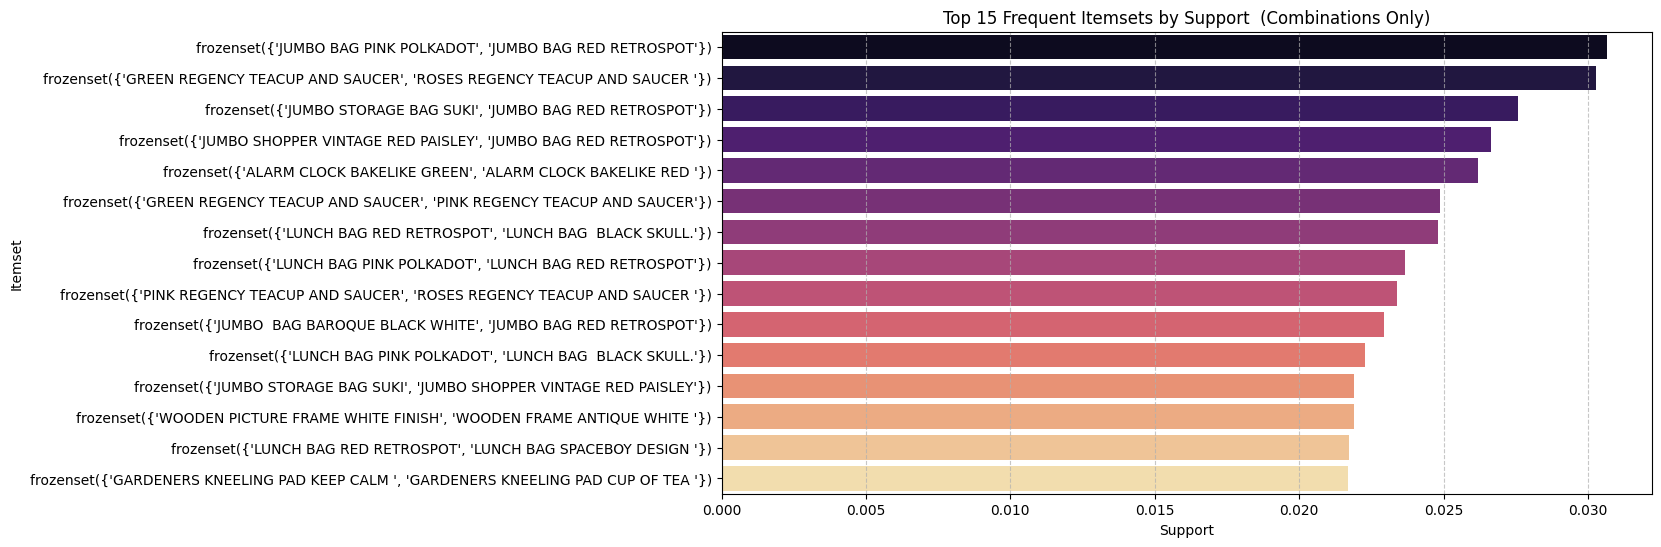

This plot highlights the items or combinations of items most commonly purchased.


C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


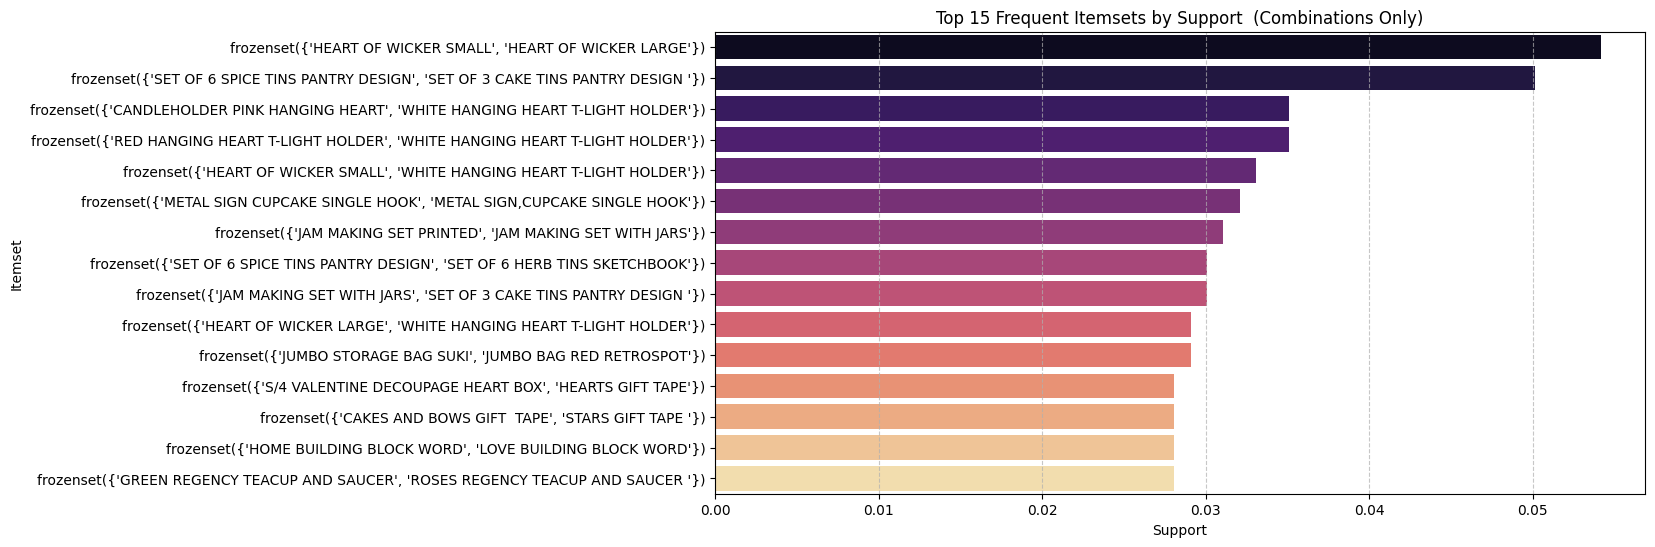

This plot highlights the items or combinations of items most commonly purchased.

--- January Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


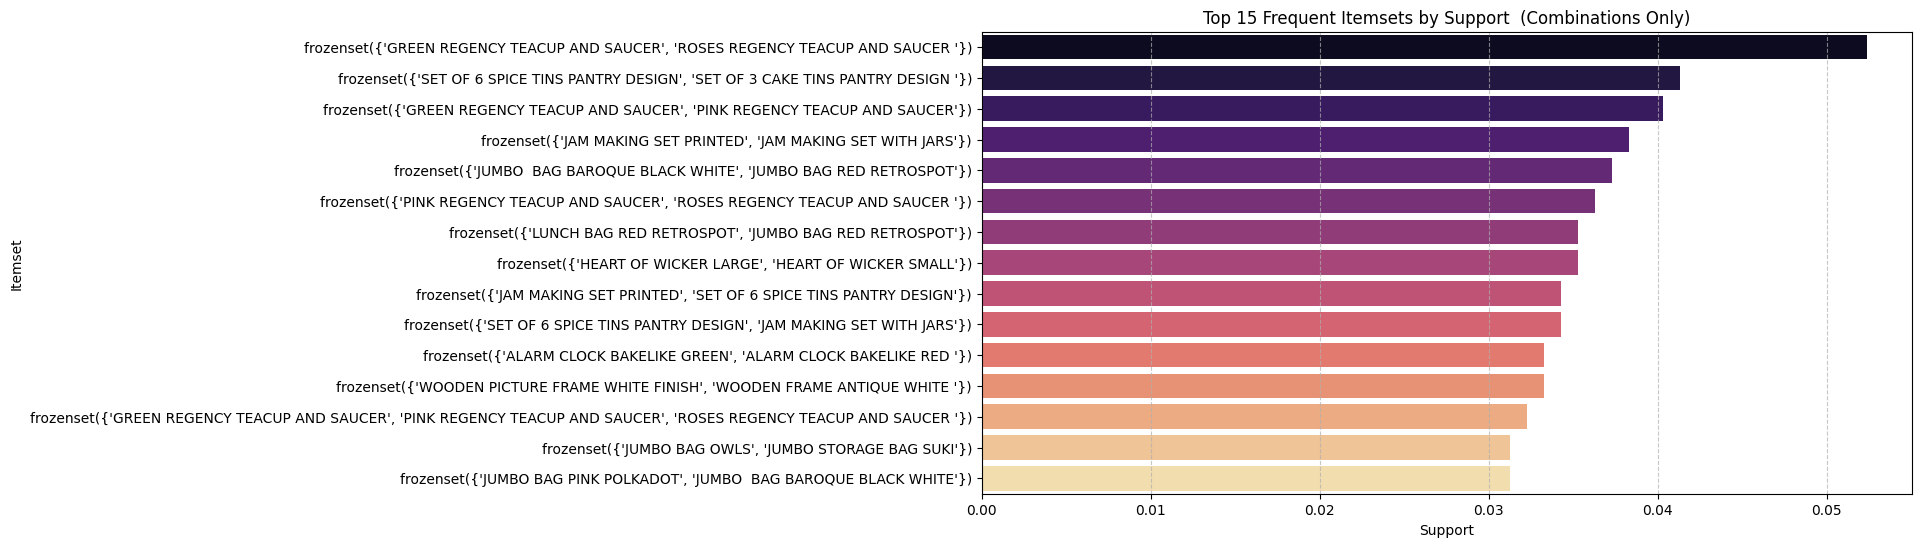

This plot highlights the items or combinations of items most commonly purchased.

--- February Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


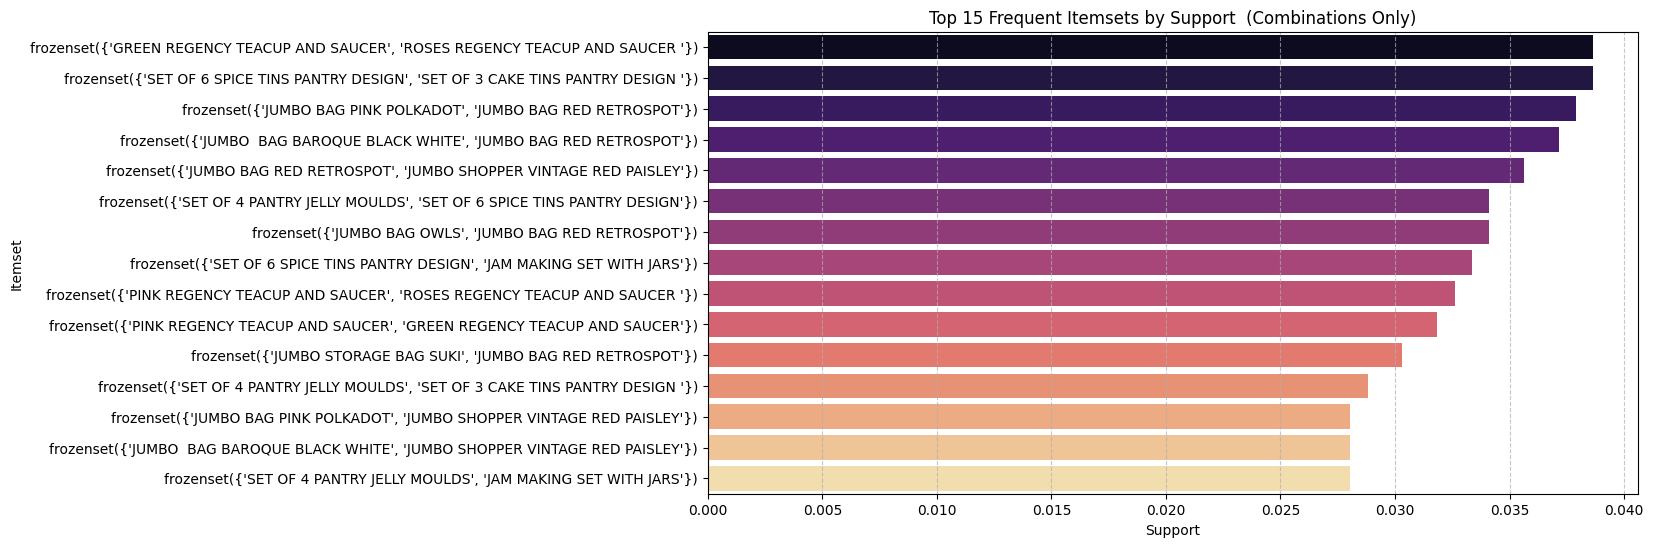

This plot highlights the items or combinations of items most commonly purchased.

--- March Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


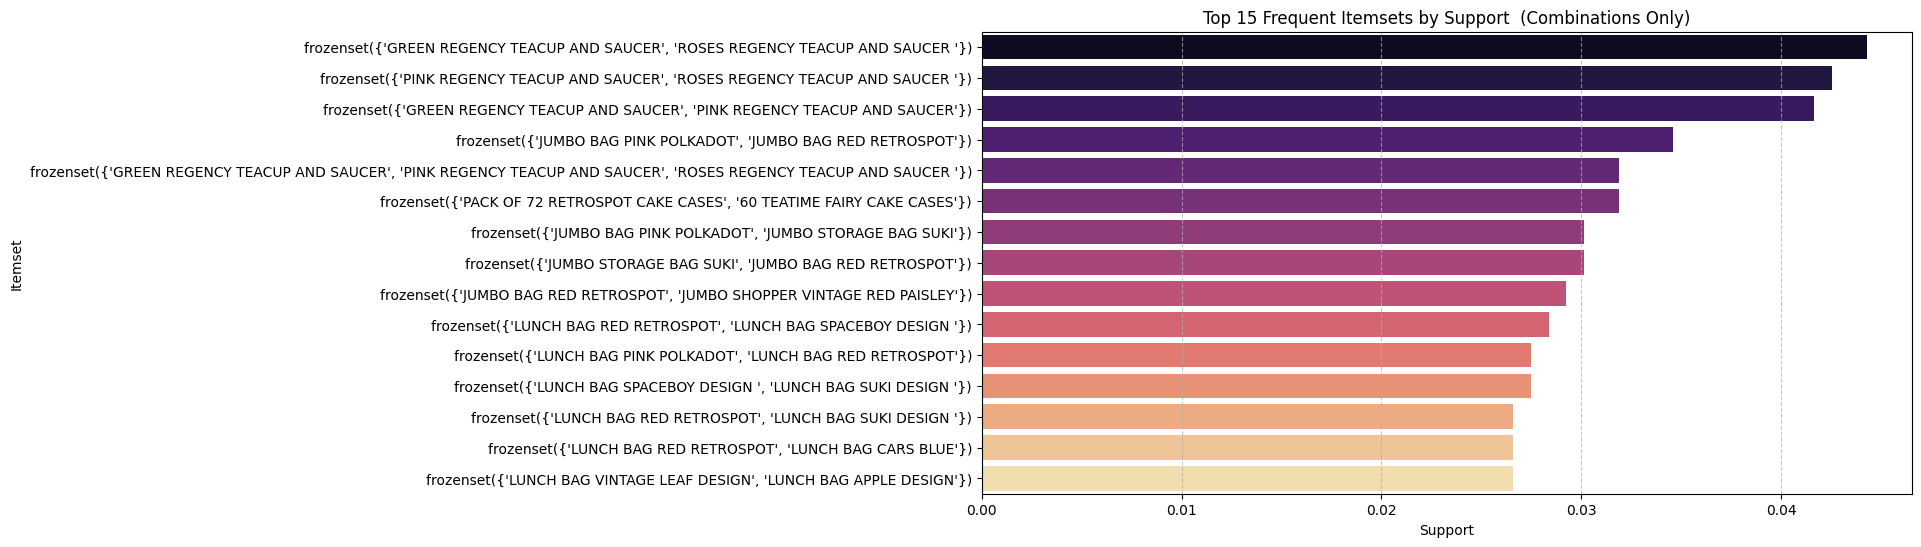

This plot highlights the items or combinations of items most commonly purchased.

--- April Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


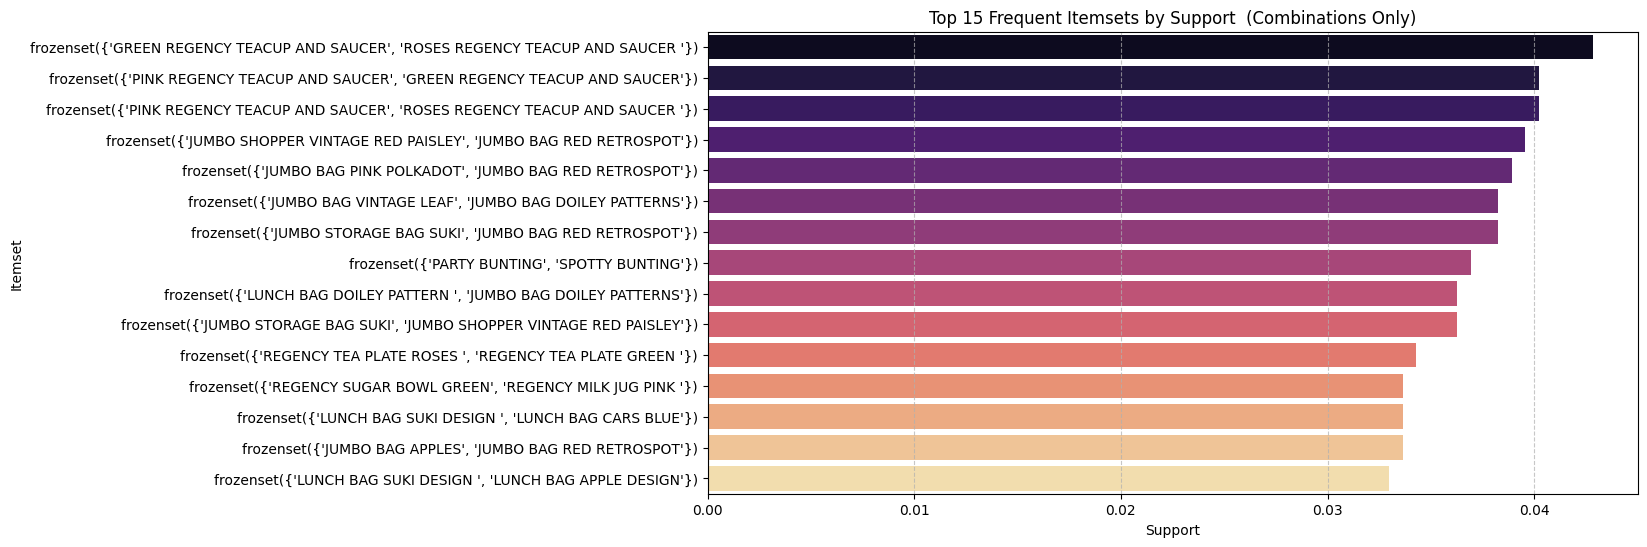

This plot highlights the items or combinations of items most commonly purchased.

--- May Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


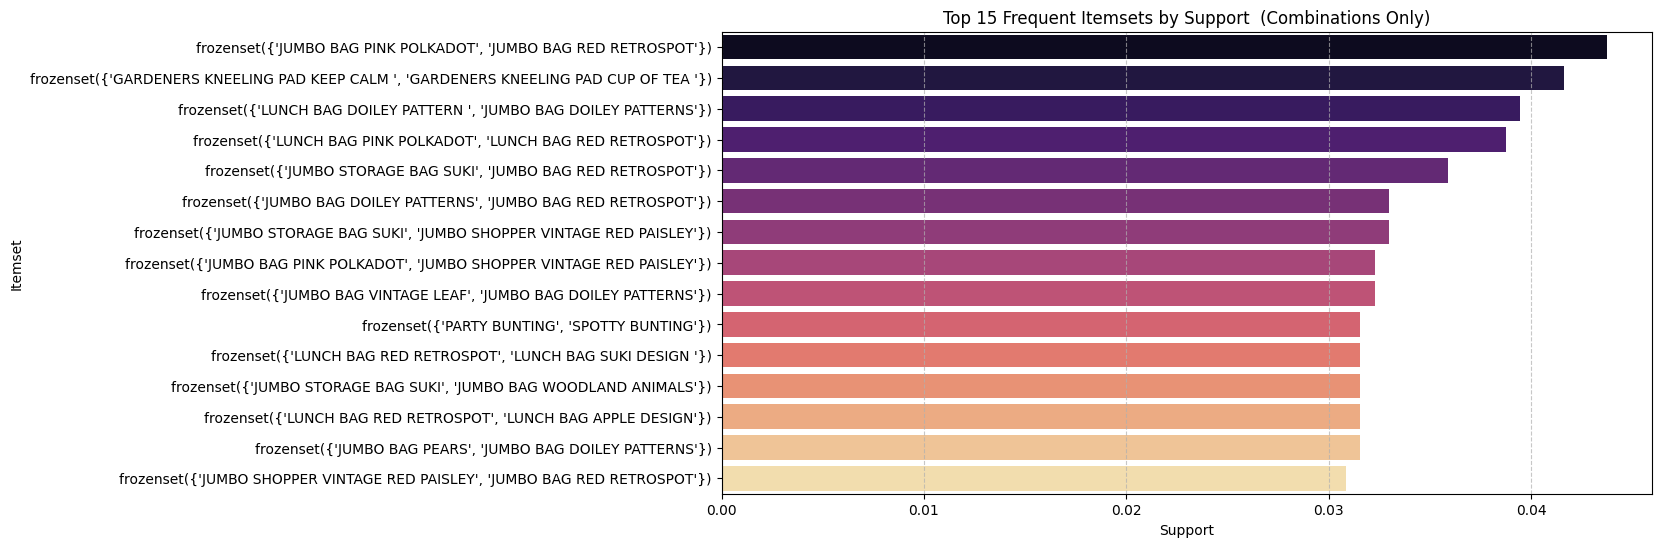

This plot highlights the items or combinations of items most commonly purchased.

--- June Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


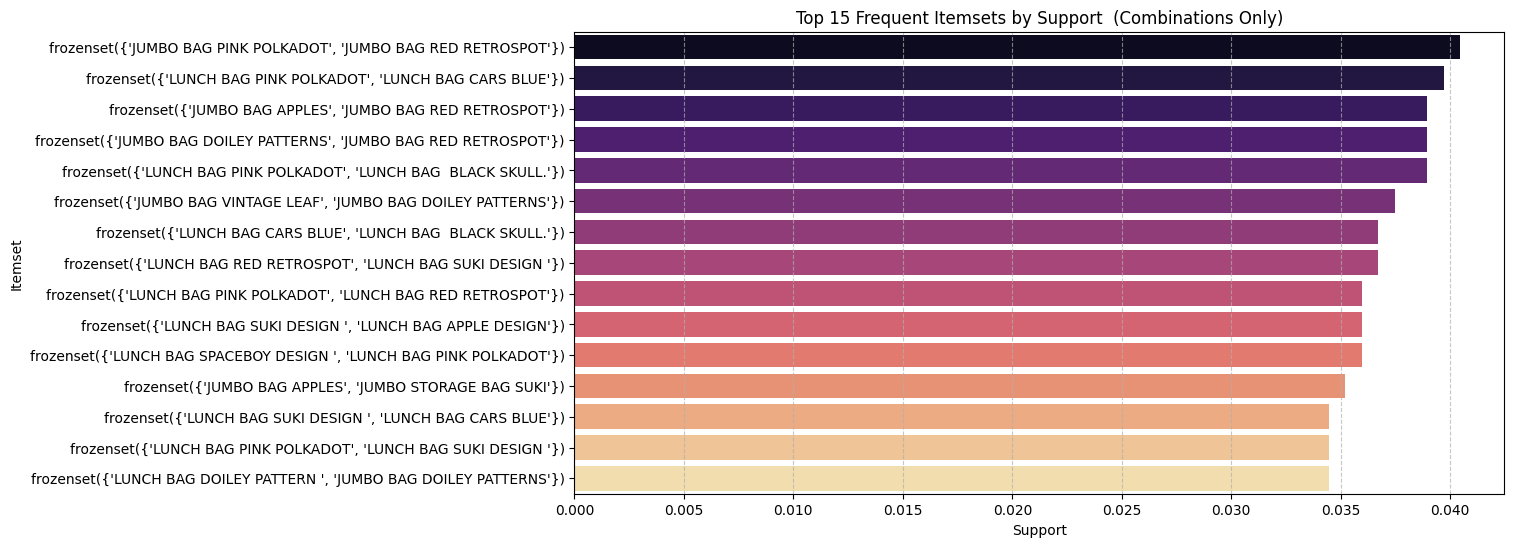

This plot highlights the items or combinations of items most commonly purchased.

--- July Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


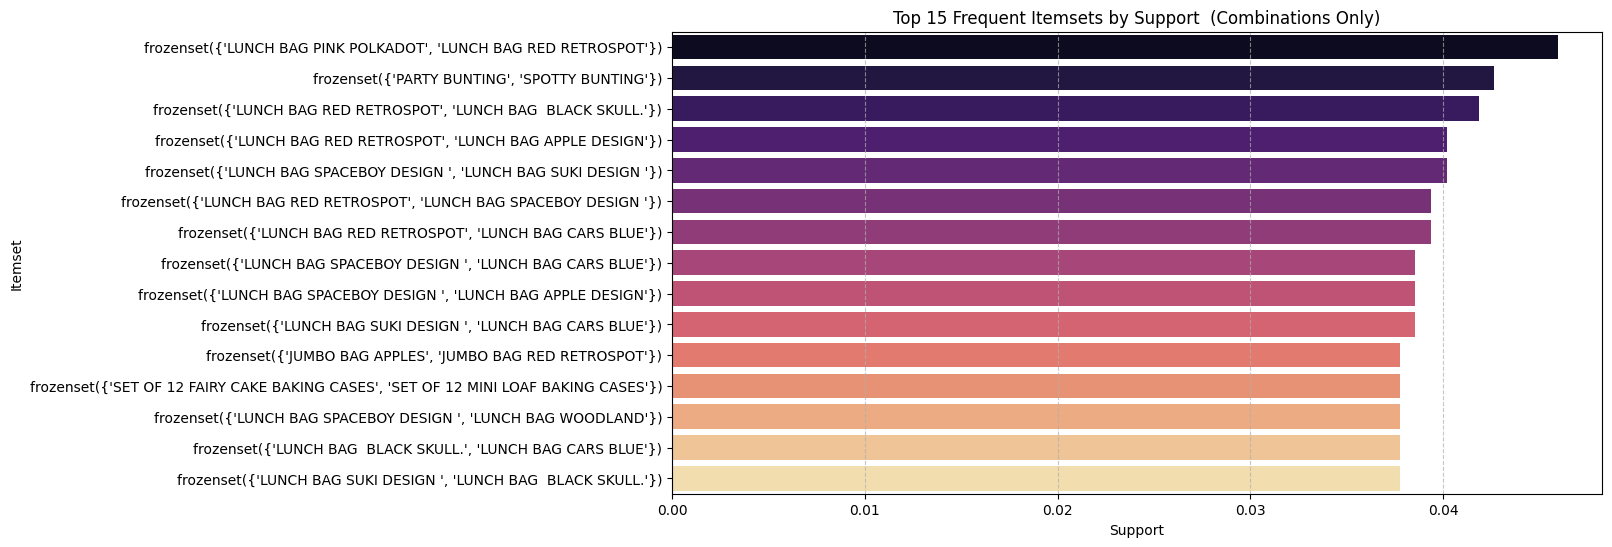

This plot highlights the items or combinations of items most commonly purchased.

--- August Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


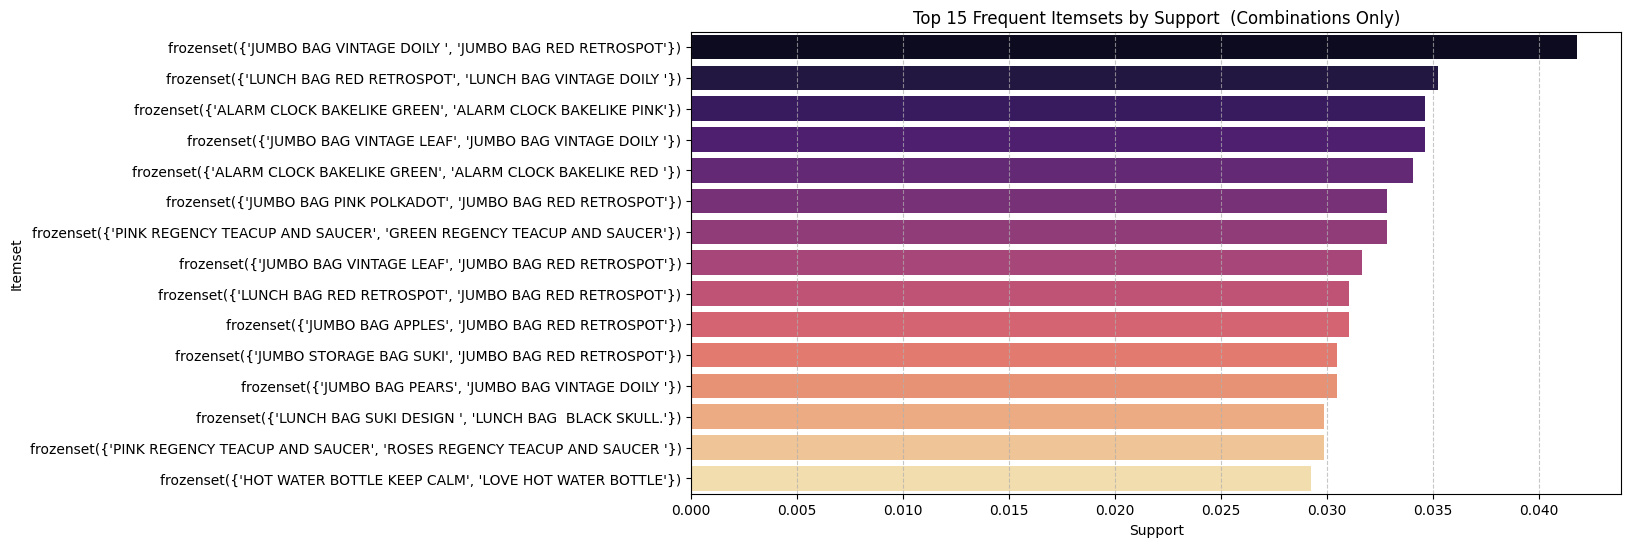

This plot highlights the items or combinations of items most commonly purchased.

--- September Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


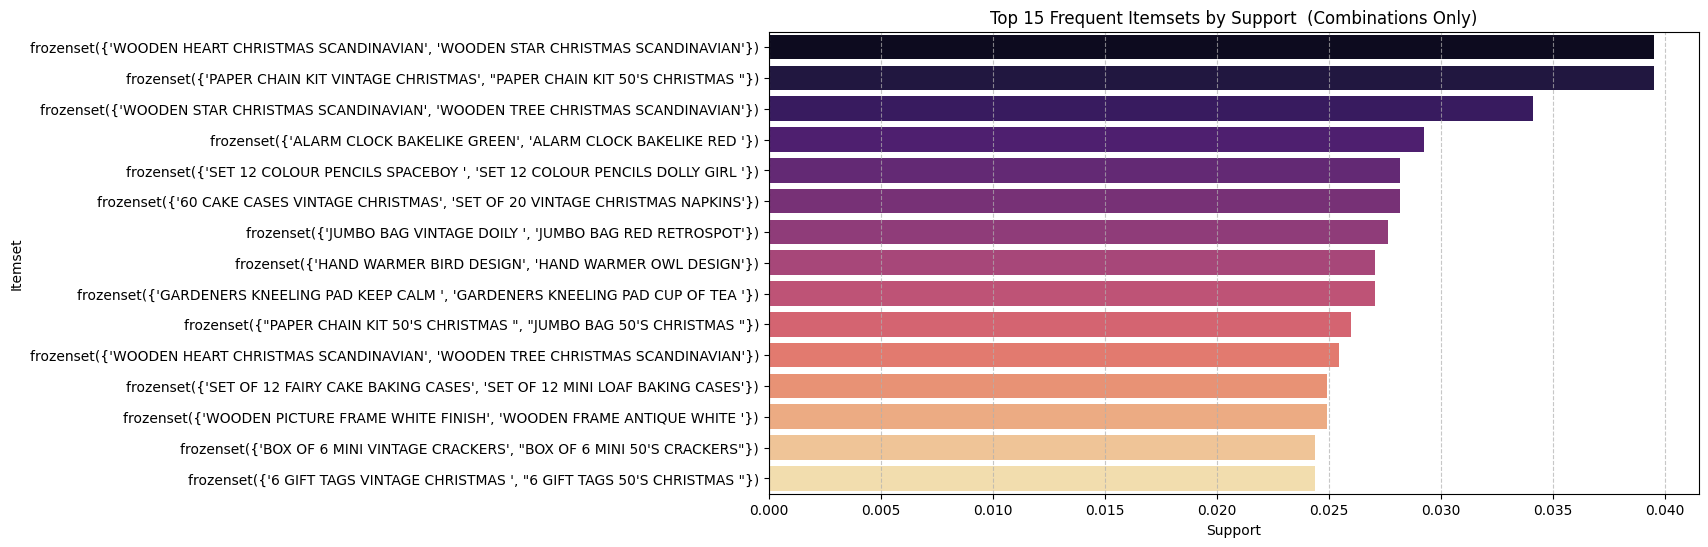

This plot highlights the items or combinations of items most commonly purchased.

--- October Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


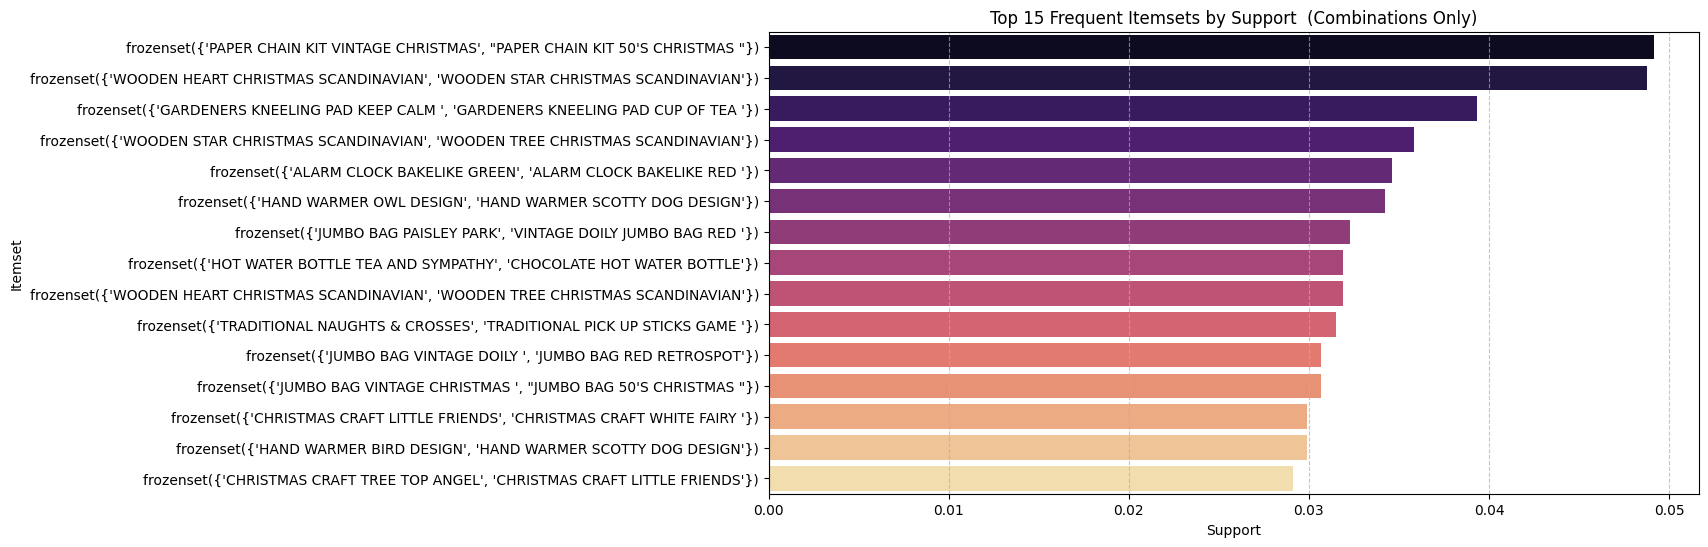

This plot highlights the items or combinations of items most commonly purchased.

--- November Itemsets Plotted ---



C:\Users\HP\AppData\Local\Temp\ipykernel_13476\459961222.py:390: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


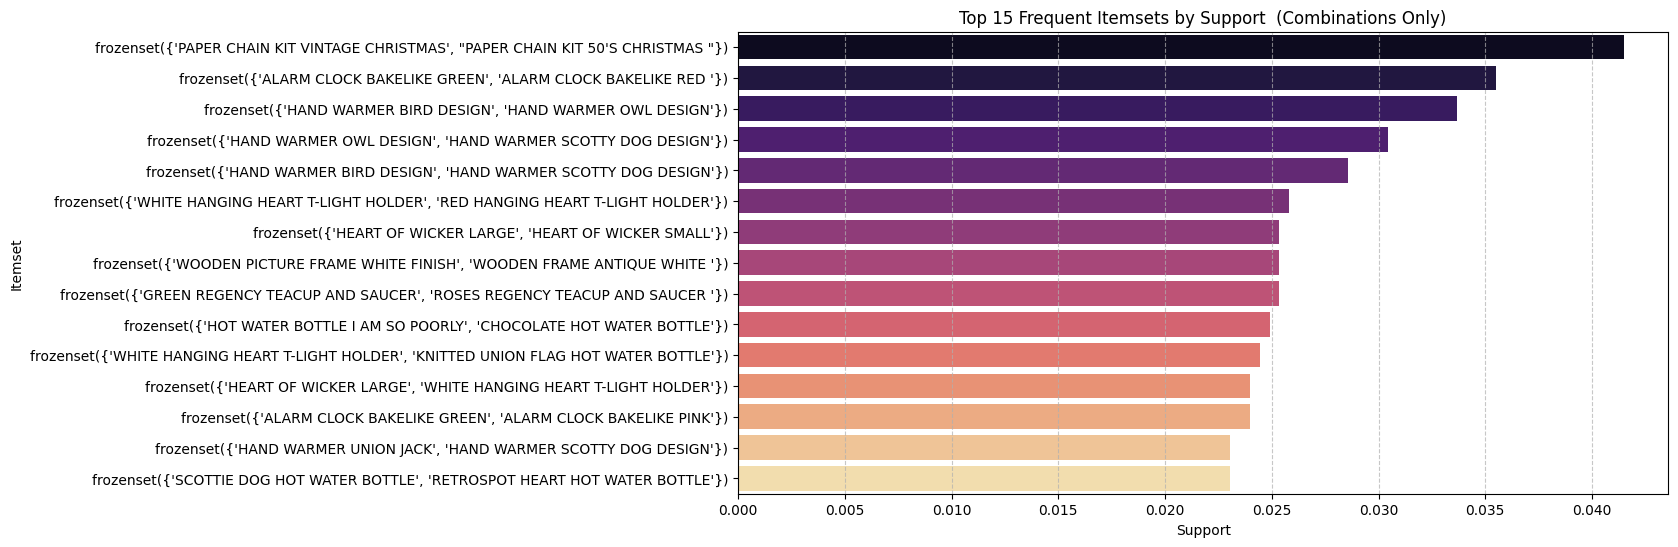

This plot highlights the items or combinations of items most commonly purchased.

--- December Itemsets Plotted ---



In [5]:
# WEEK 4: DATA MINING IMPLEMENTATION

# Member 2: RFM Calculation (pick from week 3 member 2: rfm_df)  
# Member 4: KMeans Clustering
# 1. Remove CustomerID = -1 (unknown customers) ( we kept it for apriori)
# normalisation scaling

rfm_df = rfm_df[rfm_df['CustomerID'] != '-1']
scaler = MinMaxScaler(feature_range=(0,1))
rfm_scaled = scaler.fit_transform(rfm_df[['Recency','Frequency','Monetary']])

# determine optimal clusters using silhouette score

# 1. Initialize list to store the metric
silhouette_scores = [] # Average Silhouette Score (for Silhouette Analysis)
k_range = range(2, 11) # Test k from 2 up to 10

print("--- Running K-Means and Calculating Silhouette Scores ---")
# 2. Iterate through the range of k values
for k in k_range:
    # Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(rfm_scaled)
    
    # Calculate Silhouette Score (requires at least 2 clusters)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    
    print(f"K={k}: Silhouette Score={score:.4f}")


# 3. Visualization: Silhouette Score Plot
print("\nThe optimal K is the one with the highest average Silhouette Score.")
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='red')
plt.title('Silhouette Score Analysis: Optimal K Determination')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Determine and print the optimal k based on Silhouette Score
optimal_k_index = np.argmax(silhouette_scores)
optimal_k = k_range[optimal_k_index]

print(f"\nConclusion: Based on the Silhouette Score, the statistically suggested optimal K is: {optimal_k}")
print(f"You should now update your K-Means model to use n_clusters={optimal_k} for the final segmentation.")



kmeans = KMeans(n_clusters=4, random_state=42) # 2 is best but we'll go with 4 for variety
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)
print("\nFirst 5 Customers with Cluster ID:")
print(rfm_df[['CustomerID', 'Cluster']].head())

# 3. Visualization of Clusters (Scatter Plot)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster')
plt.title("Customer Segmentation via KMeans (Frequency vs. Monetary)")
plt.show()

# The plot has an outlier(a frequent customer that also spends alot)
#  to make the plot clearer, we can limit both axes just for this plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster')
plt.xlim(0, rfm_df['Frequency'].quantile(0.95))
plt.ylim(0, rfm_df['Monetary'].quantile(0.95))
plt.title("Customer Segmentation via KMeans (Frequency vs. Monetary) - Zoomed In")
plt.show()

# Member 3: Validation

# Convert categorical columns to numeric for aggregation (pick rfm from member 2 week3)
rfm_numeric = rfm_df.copy()

# Recalculate scores on the filtered data
rfm_numeric['R'] = pd.qcut(rfm_numeric['Recency'], q=5, labels=[5,4,3,2,1])
rfm_numeric['F'] = pd.qcut(rfm_numeric['Frequency'], q=5, labels=[1,2,3,4,5])
rfm_numeric['M'] = pd.qcut(rfm_numeric['Monetary'], q=5, labels=[1,2,3,4,5])

# Convert to numeric just to be safe
rfm_numeric[['R', 'F', 'M']] = rfm_numeric[['R', 'F', 'M']].apply(pd.to_numeric)

# confirm
print(rfm_numeric.dtypes)


# 1. Cluster Validation: Analyze the mean RFM scores for each cluster
print("\nKMeans Cluster Means (Average R, F, M scores per segment):")
cluster_means = rfm_numeric.groupby('Cluster')[['R', 'F', 'M', 'Recency', 'Frequency', 'Monetary']].mean()
print(cluster_means)

# Visualize Cluster Means for clearer interpretation (optional but recommended)
rfm_melted = rfm_numeric.groupby('Cluster')[['R', 'F', 'M']].mean().reset_index()
rfm_melted = rfm_melted.melt(
    id_vars=['Cluster'],
    value_vars=['R', 'F', 'M'],
    var_name='Metric',
    value_name='Average Score'
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Average Score', hue='Metric', data=rfm_melted, palette='Set2')
plt.title('KMeans Cluster Characteristics (Average RFM Score)')
plt.show()
# Visualization 2: Cluster Sizes (Bar Plot of counts)
cluster_counts = rfm_numeric['Cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_counts)
plt.figure(figsize=(6, 5))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Customers per Segment")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.show()


# 3.  Cluster Profile Plot (Snake Plot) - Essential for Interpretation 

# Calculate the mean of the SCALED RFM metrics for each cluster
cluster_profile = rfm_numeric.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Reshape data for plotting (melt)
cluster_profile_melted = cluster_profile.melt(
    id_vars=['Cluster'],
    value_vars=['Recency', 'Frequency', 'Monetary'],
    var_name='Metric',
    value_name='Average Scaled Value'
)

# Plot 3: Snake Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=cluster_profile_melted, 
    x='Metric', 
    y='Average Scaled Value', 
    hue='Cluster', 
    marker='o', 
    palette='viridis', 
    linewidth=3
)
plt.title(f'Cluster Profile (Snake Plot) for K= 4: Average Scaled RFM Values')
plt.ylabel('Average Scaled Value ')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nSnake Plot Interpretation Keys:")
print("- High Recency (closer to 1) means very recent purchase.")
print("- Low Recency (closer to 0) means purchase was long ago.")
print("- High Frequency/Monetary (closer to 1) means high value metrics.")


# Business Insights
print("""
Cluster 0: Low value, inactive customers → offer discounts
Cluster 1: High value VIP customers → loyalty rewards
Cluster 2: New customers → onboarding campaigns
Cluster 3: Medium customers → upselling strategies
""")




# Member 2: Market Basket Analysis (Apriori Prep)
# load the encoded products data from member 4
# it is seperated by month due to the size of the data set
encoded_1= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_01.csv", index_col=0)

encoded_2= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_02.csv", index_col=0)

encoded_3= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_03.csv", index_col=0)

encoded_4= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_04.csv", index_col=0)

encoded_5= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_05.csv", index_col=0)

encoded_6= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_06.csv", index_col=0)

encoded_7= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_07.csv", index_col=0)

encoded_8= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_08.csv", index_col=0)

encoded_9= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_09.csv", index_col=0)

encoded_10= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_10.csv", index_col=0)

encoded_11= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_11.csv", index_col=0)

encoded_12= pd.read_csv(r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw\encoded_products_Month_12.csv", index_col=0)

# combine all months into one dataframe
basket_df = pd.concat([encoded_1, encoded_2, encoded_3, encoded_4, encoded_5, encoded_6, encoded_7, encoded_8, encoded_9, encoded_10, encoded_11, encoded_12], axis=0)


print("\nBasket DataFrame Head:")
print(basket_df.head())

from mlxtend.frequent_patterns import fpgrowth

# 1. OPTIMIZE MEMORY: Convert to boolean (0/1) to reduce RAM usage significantly
basket_df = basket_df.fillna(0).astype(bool)

print("\nNulls after fill:", basket_df.isna().sum().sum())
print("dtypes (sample):", basket_df.dtypes.head())
print(f"Basket size: {basket_df.shape}")

print("--- Running FP-Growth on combined dataset ---")
# 2. Apply FP-Growth Algorithm (Memory-efficient alternative to Apriori)
frequent_items = fpgrowth(basket_df, min_support=0.02, use_colnames=True) 

print("\nFrequent Items (min_support=0.02) Head:")
print(frequent_items.head())

# 3. Generate Association Rules (min_threshold=0.3)
rules = association_rules(frequent_items, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules (confidence >= 0.3):")

# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# --- SAVE THE RULES HERE FOR WEEK 5 ---
output_path = r"C:\Users\HP\Documents\edu\data mining\group work\DataMining_GroupProject_EcomAnalytics\data\raw"
rules_export = rules[rules['lift'] > 1]
rules_export.to_csv(f"{output_path}\\market_basket_rules.csv", index=False)
print(f"\nMarket basket rules saved to {output_path}\\market_basket_rules.csv")

# now apriori for each month
# January
# Apply Apriori Algorithm
frequent_items_J = apriori(encoded_1, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head:")
print(frequent_items_J.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_J, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Jan (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())


# February
# 2. Apply Apriori Algorithm
frequent_items_F = apriori(encoded_2, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head:")
print(frequent_items_F.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_F, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Feb (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# March
# 2. Apply Apriori Algorithm
frequent_items_M = apriori(encoded_3, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head:")
print(frequent_items_M.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_M, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Mar (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# April
# 2. Apply Apriori Algorithm
frequent_items_A = apriori(encoded_4, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head:")
print(frequent_items_A.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_A, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Apr (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# May
# 2. Apply Apriori Algorithm
frequent_items_Ma = apriori(encoded_5, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_Ma.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_Ma, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules May (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# June
# 2. Apply Apriori Algorithm
frequent_items_Ju = apriori(encoded_6, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_Ju.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_Ju, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Jun (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# July
# 2. Apply Apriori Algorithm
frequent_items_Jul = apriori(encoded_7, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_Jul.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_Jul, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Jul (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# August
# 2. Apply Apriori Algorithm
frequent_items_Au = apriori(encoded_8, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_Au.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_Au, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Aug (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# September
# 2. Apply Apriori Algorithm
frequent_items_S = apriori(encoded_9, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_S.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_S, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Sep (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# October
# 2. Apply Apriori Algorithm
frequent_items_O = apriori(encoded_10, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_O.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_O, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Oct (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# November
# 2. Apply Apriori Algorithm
frequent_items_N = apriori(encoded_11, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_N.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_N, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Nov (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# December
# 2. Apply Apriori Algorithm
frequent_items_D = apriori(encoded_12, min_support=0.02, use_colnames=True)
print("\nFrequent Items (min_support=0.02) Head :")
print(frequent_items_D.head())
# Generate Association Rules (min_threshold=0.3 )
rules = association_rules(frequent_items_D, metric="confidence", min_threshold=0.3)
print("\nTop Association Rules Dec (confidence >= 0.3):")
# Focus on the most important metrics
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

# Market Basket Validation: Review top rules (reconfirming output)
print("Top Association Rules:\n", rules[['antecedents','consequents','support','confidence','lift']].head())




# 1. Bar Plot of Top Frequent Itemsets (by Support)
def plot_top_itemsets(frequent_items, top_n, combinations_only=False):
    """
    Visualizes the support for the top N frequent itemsets.
    If combinations_only is True, only itemsets with 2 or more items are shown.
    """
    
    df_to_plot = frequent_items.copy()
    
    if combinations_only:
        # Filter for itemsets containing 2 or more items
        df_to_plot = df_to_plot[df_to_plot['itemsets'].apply(lambda x: len(x) > 1)]
        title_suffix = " (Combinations Only)"
    else:
        title_suffix = ""

    # Sort and take the top N
    frequent_items_sorted = df_to_plot.sort_values(by='support', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='support', 
        y='itemsets', 
        data=frequent_items_sorted, 
        palette='magma'
    )
    plt.title(f'Top {top_n} Frequent Itemsets by Support {title_suffix}')
    plt.xlabel('Support')
    plt.ylabel('Itemset')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    if combinations_only and frequent_items_sorted.empty:
         print(f"No itemsets with 2 or more items met the required support threshold.")
    else:
        print(f"This plot highlights the items or combinations of items most commonly purchased.")

# 2. Scatter Plot of Association Rules (Confidence vs. Support vs. Lift)
def plot_association_rules(rules):
    """Visualizes the quality of association rules."""
    
    # Ensure rules are ready for plotting (Lift > 1 is usually the focus)
    rules_plot = rules[rules['lift'] > 1.0].copy()
    
    plt.figure(figsize=(12, 8))
    
    # Scatter plot: Confidence on Y, Support on X, Lift determines point size/color
    sns.scatterplot(
        x='support', 
        y='confidence', 
        size='lift', 
        hue='lift', 
        data=rules_plot, 
        palette='Spectral',
        sizes=(50, 500), # Range of marker sizes
        alpha=0.7
    )
    
    plt.title(f'Association Rules Quality (Support vs. Confidence)')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.legend(title='Lift')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Optional: Highlight the top 3 rules by Lift
    top_rules = rules_plot.nlargest(3, 'lift')
    for i, row in top_rules.iterrows():
        plt.annotate(
            f'Lift:{row["lift"]:.2f}',
            (row['support'], row['confidence']),
            textcoords="offset points", 
            xytext=(0,10), 
            ha='center', 
            fontsize=9,
            color='darkred'
        )
    
    plt.show()
    print("Interpretation of Rule Scatter Plot:")
    print("1. Look for points in the upper-right corner (High Support, High Confidence).")
    print("2. Prioritize points with large size and warm color (High Lift) - these are the most valuable rules.")

plot_top_itemsets(frequent_items, top_n=15, combinations_only=True)


# plot monthly visualisations
# January
plot_top_itemsets(frequent_items_J, top_n=15, combinations_only=True)
print("\n--- January Itemsets Plotted ---\n")

# February
plot_top_itemsets(frequent_items_F, top_n=15, combinations_only=True)
print("\n--- February Itemsets Plotted ---\n")   

# March 
plot_top_itemsets(frequent_items_M, top_n=15, combinations_only=True)
print("\n--- March Itemsets Plotted ---\n")

# April
plot_top_itemsets(frequent_items_A, top_n=15, combinations_only=True)
print("\n--- April Itemsets Plotted ---\n")

# May
plot_top_itemsets(frequent_items_Ma, top_n=15, combinations_only=True)
print("\n--- May Itemsets Plotted ---\n")

# June
plot_top_itemsets(frequent_items_Ju, top_n=15, combinations_only=True)
print("\n--- June Itemsets Plotted ---\n")

# July
plot_top_itemsets(frequent_items_Jul, top_n=15, combinations_only=True)
print("\n--- July Itemsets Plotted ---\n")

# August
plot_top_itemsets(frequent_items_Au, top_n=15, combinations_only=True)
print("\n--- August Itemsets Plotted ---\n")

# September
plot_top_itemsets(frequent_items_S, top_n=15, combinations_only=True)
print("\n--- September Itemsets Plotted ---\n")

# October
plot_top_itemsets(frequent_items_O, top_n=15, combinations_only=True)
print("\n--- October Itemsets Plotted ---\n")

# November
plot_top_itemsets(frequent_items_N, top_n=15, combinations_only=True)
print("\n--- November Itemsets Plotted ---\n")

# December
plot_top_itemsets(frequent_items_D, top_n=15, combinations_only=True)
print("\n--- December Itemsets Plotted ---\n")